<h2 align="center">CYFLOD: Cyclic Filtering and Loss Damping for Alleviating Noisy Labels in Fine-grained Visual Classification</h2>
<h3 align="center">Submission: 1008.</h3>
<h3 align="center">Aircraft-Asymmetric Noise 10%</h3>

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from fastai.vision.widgets import ImageClassifierCleaner
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from fastai import optimizer, losses, metrics
from functools import partial, wraps
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastai import __version__
import torchvision
import fastai
import pandas as pd
from pathlib import Path
import seaborn as sns
import random as rn
import torch
import random
import os.path
import math
import shutil
import os

In [2]:
print(fastai.__version__)
print(torch.__version__)
print(torchvision.__version__)

2.6.3
1.11.0
0.12.0


In [3]:
noise_ratio = 0.1
loss_function = 'DampedGCELoss' 
dataset = 'aircrafts'
noise_type = 'asym'
baseline = 'baseline'
scheme = 'scheme'
feat = 'baseline_features'
num_classes  = 100
damp_1 = 0.25
damp_2 = 0.50
best_pth = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+baseline
feature_path = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+feat
damp_1_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_1_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_2_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)
damp_2_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)

print(f'Best model: {best_pth}')
print(f'Model Features: {feature_path}')
print(f'Saving features from Scheme delta = 0.25: {damp_1_features}')
print(f'Csv save: {damp_1_csvs}')
print(f'Saving features from Scheme delta = 0.25: {damp_2_features}')
print(f'Saving csv for damp_2: {damp_2_csvs}')

Best model: DampedGCELoss_aircrafts_asym_0.1_0.25_baseline
Model Features: DampedGCELoss_aircrafts_asym_0.1_0.25_baseline_features
Saving features from Scheme delta = 0.25: DampedGCELoss_aircrafts_asym_0.1_0.25
Csv save: DampedGCELoss_aircrafts_asym_0.1_0.25
Saving features from Scheme delta = 0.25: DampedGCELoss_aircrafts_asym_0.1_0.5
Saving csv for damp_2: DampedGCELoss_aircrafts_asym_0.1_0.5


# Declaration of Efficient Net family with Resolution, Epochs, Learning Rate, Batch size and Label smoothing values

In [3]:
architecture = 'efficientnet-b4'

effnet_size = ({
    'efficientnet-b0':300,      # original resolution
    'efficientnet-b1':240,      # original resolution
    'efficientnet-b2':260,      # original resolution
    'efficientnet-b3':400,      # original resolution
    'efficientnet-b4':450,      # original resolution
    'efficientnet-b5':456,      # original resolution
    'efficientnet-b6':528,      # original resolution
    'efficientnet-b7':600,      # original resolution
    'efficientnet-lite0':224,
    'efficientnet-lite2':260,
    'efficientnet-lite4':384,
    'resnet18':224,
    'resnet34':224,
    'resnet50':224,
    'resnet101':224,
    'resnet152':224
})
batch_size = ({ 
    'efficientnet-b0':128, # bs = 256 for B1
    'efficientnet-b1':120,      #
    'efficientnet-b2':160,       #88 160
    'efficientnet-b3':16,       #
    'efficientnet-b4':16,       #
    'efficientnet-b5':14,       #
    'efficientnet-b6':16,
    'efficientnet-b7':8,
    'efficientnet-lite0': 160,
    'efficientnet-lite2': 160,
    'efficientnet-lite4':24,
    
    'resnet18':400,             # 3080: ok
    'resnet34':320,            # RTX 3090 rocz!
    'resnet50':256,             # 3080: ok
    'resnet101':96,
    'resnet152':64
})

 # Writing training data into csv

In [4]:
import pandas as pd
train_df = pd.read_csv(dataset+"_"+noise_type+"_"+str(noise_ratio)+".csv")
train_df

,Filepath,Noisy_labels,Label,Label_numeric
0,aircrafts_original/0/0716386.jpg,1,0,0
1,aircrafts_original/0/0810608.jpg,1,0,0
2,aircrafts_original/0/1427680.jpg,1,0,0
3,aircrafts_original/0/1017179.jpg,1,0,0
4,aircrafts_original/0/0536721.jpg,1,0,0
...,...,...,...,...
6662,aircrafts_original/99/1117057.jpg,99,99,99
6663,aircrafts_original/99/1026133.jpg,99,99,99
6664,aircrafts_original/99/0730106.jpg,99,99,99
6665,aircrafts_original/99/1801242.jpg,99,99,99


In [5]:
print(train_df.Noisy_labels.tolist())

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

# Viualization of Training Data, Samples per class

Text(0, 0.5, 'Number of Images')

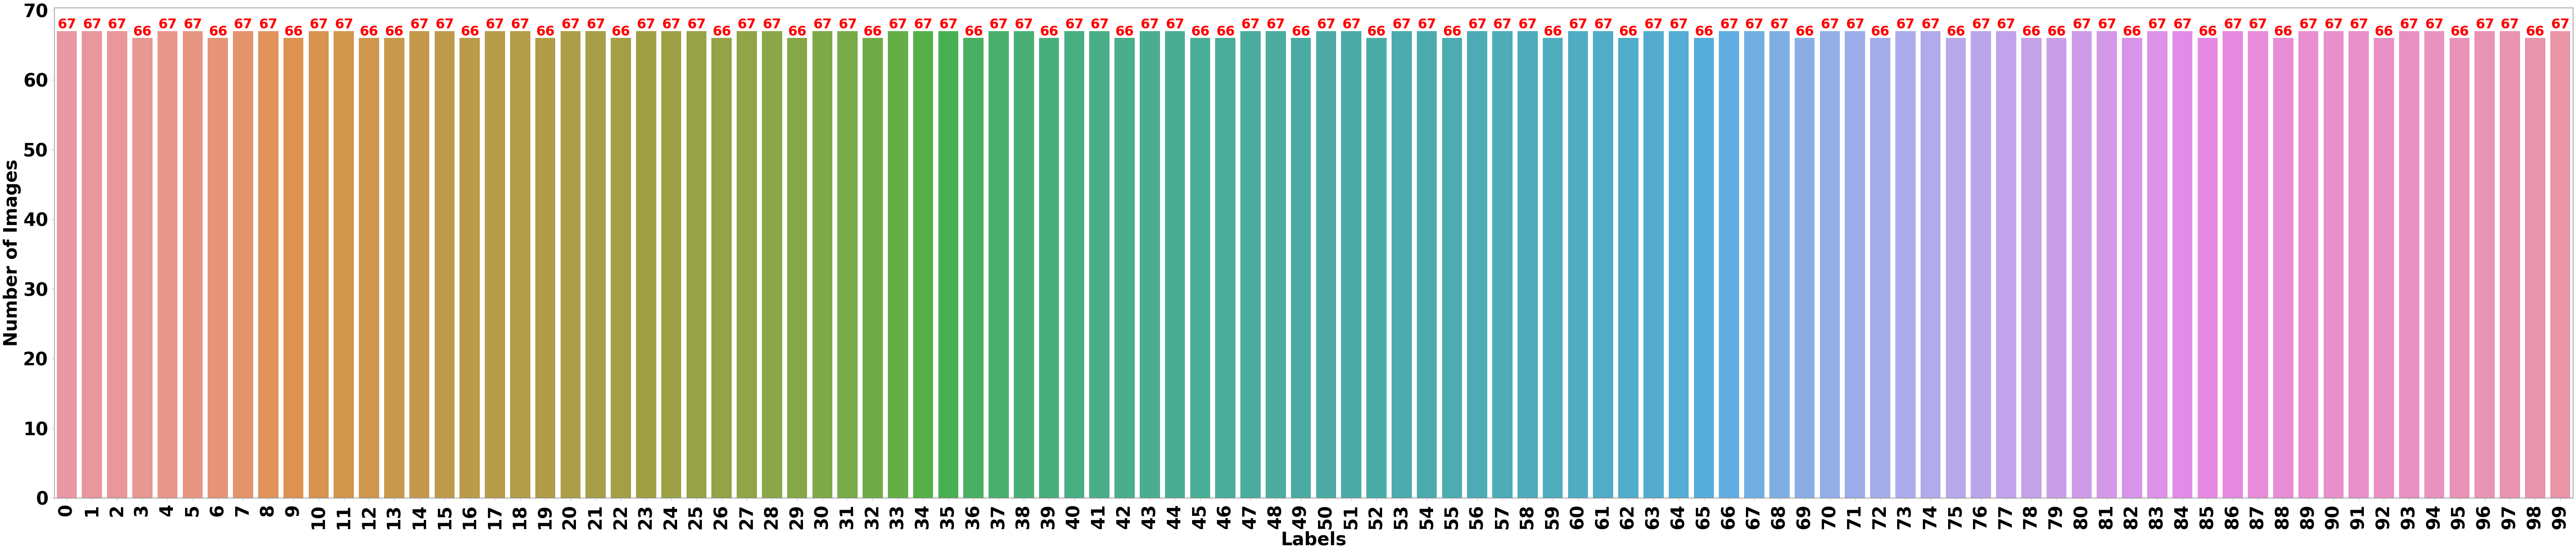

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.facecolor'] = 'white'
lbl = train_df['Label_numeric']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(100,20))
ax = sns.countplot(x= lbl, data=train_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Images Per Catergory

In [7]:
number_classes = train_df['Label'].nunique()
print("Number of classes:", number_classes)
counted = train_df.groupby(["Label"]).size()
print(counted)

Number of classes: 100
Label
0     67
1     67
2     66
3     67
4     67
      ..
95    66
96    67
97    67
98    66
99    67
Length: 100, dtype: int64


# Writing testing  Data into CSV  (Test data frame df)

In [8]:
from pathlib import Path
import os.path
test_dir = "testing"
test_path = Path(test_dir)
filepaths = list(test_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
test_df = pd.DataFrame(images)
test_df

,Filepath,Label
0,testing/32/1691545.jpg,32
1,testing/32/2212521.jpg,32
2,testing/32/1508910.jpg,32
3,testing/32/1260329.jpg,32
4,testing/32/0199985.jpg,32
...,...,...
3328,testing/42/0773394.jpg,42
3329,testing/42/0875337.jpg,42
3330,testing/42/0759282.jpg,42
3331,testing/42/2228007.jpg,42


In [9]:
test_df['Label'] = test_df['Label'].map(lambda x: x.lower())

In [10]:
sorted_df = test_df.sort_values(by='Label').reset_index(drop=True)
sorted_df

,Filepath,Label
0,testing/0/0789828.jpg,0
1,testing/0/1453508.jpg,0
2,testing/0/0895165.jpg,0
3,testing/0/0536515.jpg,0
4,testing/0/0747566.jpg,0
...,...,...
3328,testing/99/0973160.jpg,99
3329,testing/99/0197892.jpg,99
3330,testing/99/1176955.jpg,99
3331,testing/99/1298910.jpg,99


In [11]:
my_list = sorted_df.Label.unique()

In [12]:
my_dict = {value: index for index, value in enumerate(my_list)}

In [13]:
sorted_df['Label_numeric'] = sorted_df['Label'].map(my_dict)
sorted_df

,Filepath,Label,Label_numeric
0,testing/0/0789828.jpg,0,0
1,testing/0/1453508.jpg,0,0
2,testing/0/0895165.jpg,0,0
3,testing/0/0536515.jpg,0,0
4,testing/0/0747566.jpg,0,0
...,...,...,...
3328,testing/99/0973160.jpg,99,99
3329,testing/99/0197892.jpg,99,99
3330,testing/99/1176955.jpg,99,99
3331,testing/99/1298910.jpg,99,99


In [14]:
test_df = sorted_df[['Filepath', 'Label_numeric', 'Label']]
test_df

,Filepath,Label_numeric,Label
0,testing/0/0789828.jpg,0,0
1,testing/0/1453508.jpg,0,0
2,testing/0/0895165.jpg,0,0
3,testing/0/0536515.jpg,0,0
4,testing/0/0747566.jpg,0,0
...,...,...,...
3328,testing/99/0973160.jpg,99,99
3329,testing/99/0197892.jpg,99,99
3330,testing/99/1176955.jpg,99,99
3331,testing/99/1298910.jpg,99,99


In [15]:
label_counts = sorted_df['Label_numeric'].value_counts().sort_index().tolist()
print(label_counts)

[33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33]


In [16]:
labels = sorted_df.Label_numeric.tolist()
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

Text(0, 0.5, 'Number of Images')

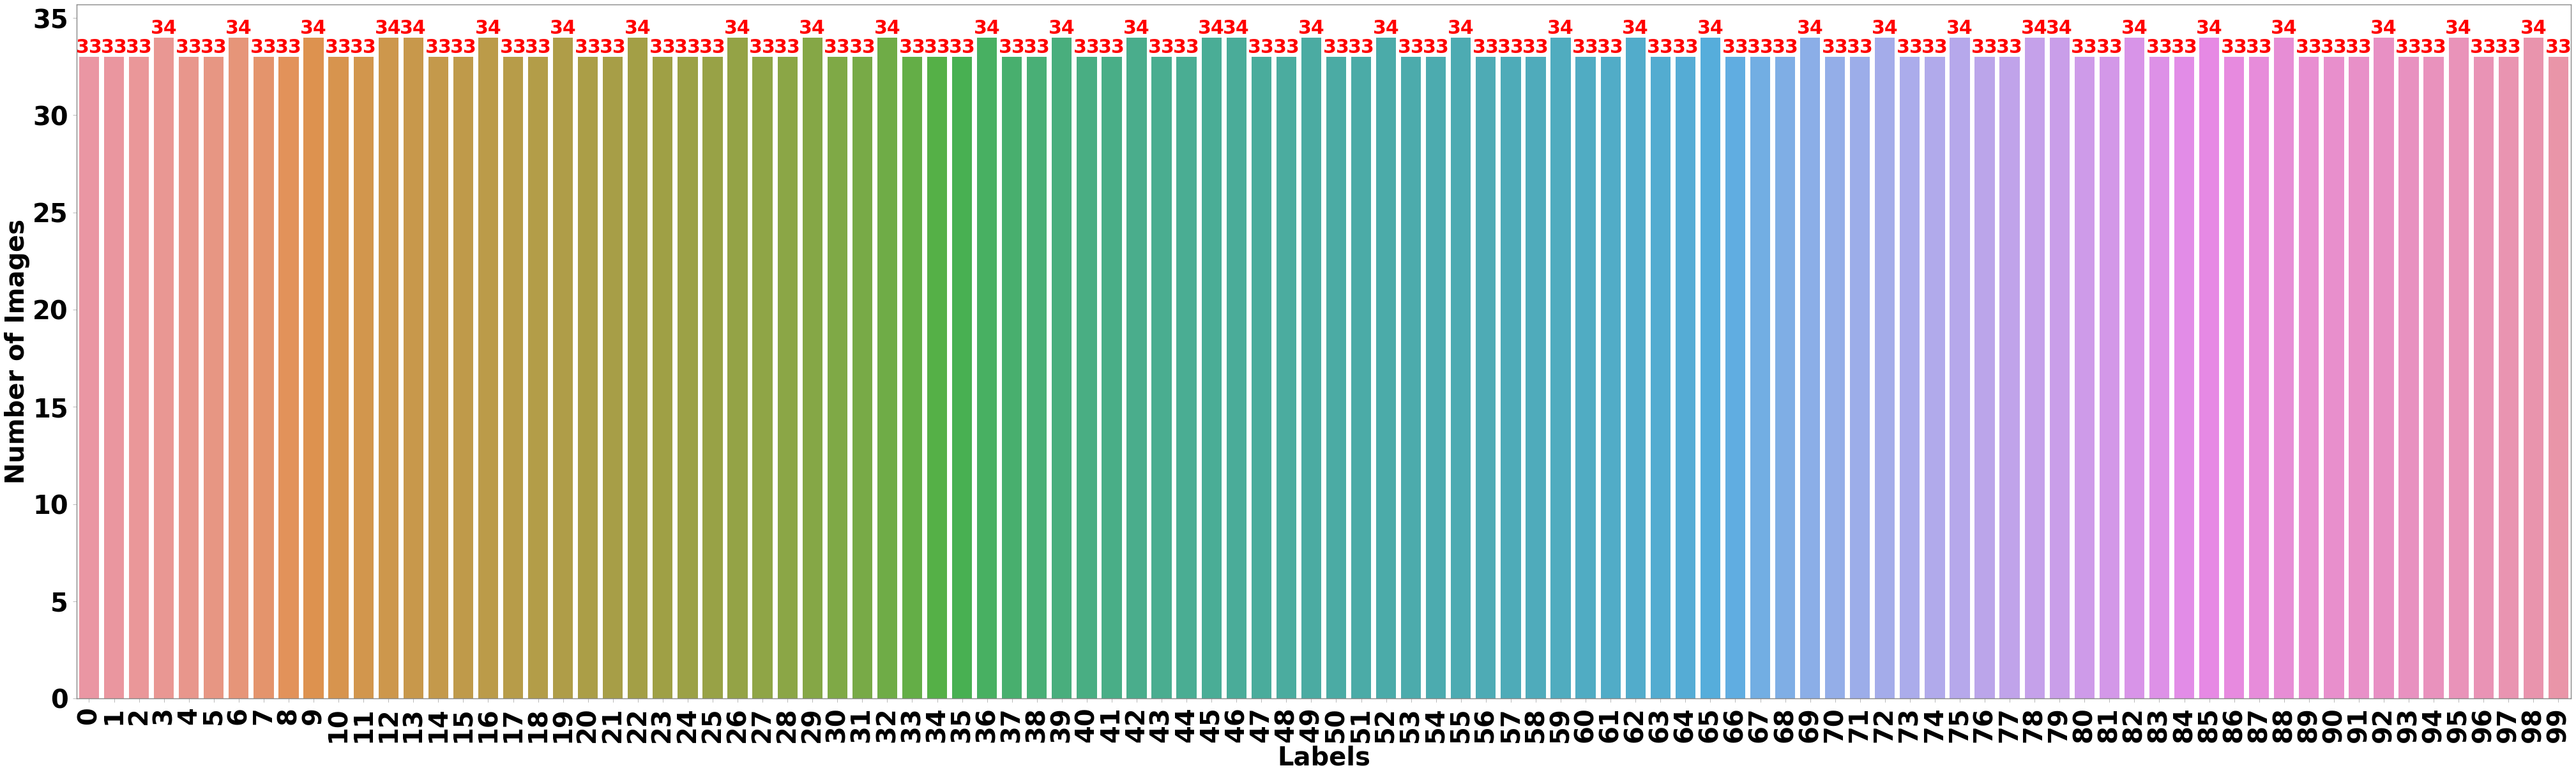

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
lbl = test_df['Label_numeric']
plt.figure(figsize=(70,20))
ax = sns.countplot(x= lbl, data=test_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Preparation of data for learner (Fastai learner)

In [21]:
batch_tfms = [Zoom(),Rotate(), Flip(), Brightness(), Contrast(), Saturation()]

In [22]:
bs   = batch_size[architecture]
imgs = effnet_size[architecture]
resize = (imgs*4)//3
data0 = (ImageDataLoaders.from_df(train_df, valid_pct=0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))
print("Image size=", imgs)
print("Batch size=", bs)
print("Architecture=", architecture)
print(resize)

Image size= 450
Batch size= 16
Architecture= efficientnet-b4
600


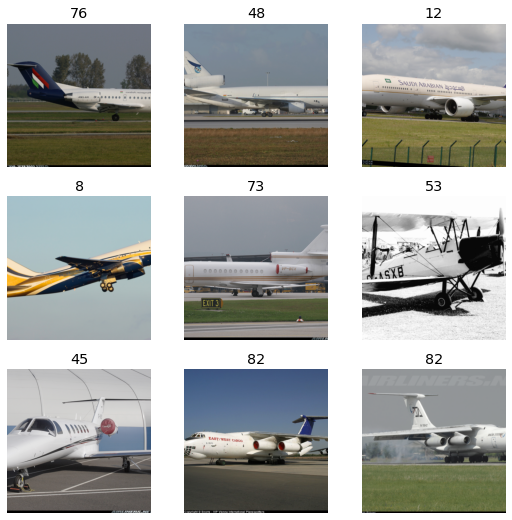

In [23]:
data0.show_batch()

In [24]:
import damped_losses as losses
loss_func = losses.DampedGCELossFlat(num_classes=num_classes,q=0.5, delta = 0.0, reduction='mean')
model = EfficientNet.from_pretrained(architecture, num_classes=num_classes)
learner_type = Learner

Loaded pretrained weights for efficientnet-b4


In [25]:
best_pth = best_pth
checkpoints = SaveModelCallback(fname=best_pth,monitor='accuracy',comp=np.greater, with_opt=True)
learn = ( learner_type(data0, model,metrics=[accuracy],loss_func=loss_func,
                        cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
print("Best pth is=", best_pth)

Best pth is= gce_aircrafts_asym_0.1_baseline


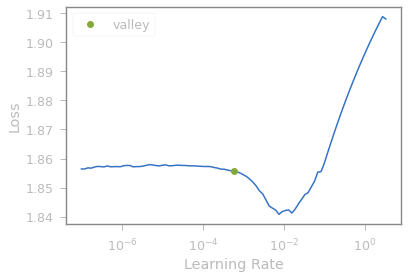

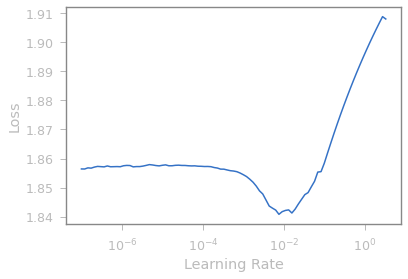

In [26]:
learn.lr_find()
learn.recorder.plot_lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.589362,1.429073,0.204801,01:50
1,1.138054,1.112429,0.357839,01:48
2,0.962258,1.072508,0.391598,01:48
3,0.781822,0.707894,0.597899,01:48
4,0.673999,0.732294,0.573893,01:48
5,0.520206,0.555258,0.686422,01:48
6,0.399637,0.486417,0.722431,01:48
7,0.309177,0.395477,0.787697,01:49
8,0.254447,0.385733,0.786947,01:48
9,0.216756,0.385629,0.787697,01:49


Better model found at epoch 0 with accuracy value: 0.20480120182037354.


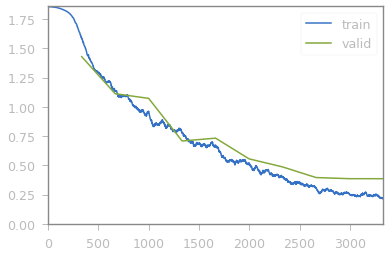

Better model found at epoch 1 with accuracy value: 0.3578394651412964.
Better model found at epoch 2 with accuracy value: 0.3915978968143463.
Better model found at epoch 3 with accuracy value: 0.5978994965553284.
Better model found at epoch 5 with accuracy value: 0.6864216327667236.
Better model found at epoch 6 with accuracy value: 0.7224305868148804.
Better model found at epoch 7 with accuracy value: 0.787696897983551.


In [27]:
low_lr = 1e-4
lr = 1e-3
learn.fit_one_cycle(10, lr_max = slice(low_lr, lr))

In [28]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.253022,0.383580,0.786947,01:49
1,0.246176,0.380247,0.792948,01:49
2,0.217964,0.402912,0.781695,01:49
3,0.219242,0.410769,0.776444,01:48
4,0.312934,0.441518,0.753188,01:48
5,0.277248,0.484346,0.729932,01:49
6,0.320927,0.513919,0.713428,01:48
7,0.337611,0.535370,0.711178,01:49
8,0.403383,0.533103,0.705926,01:49
9,0.398552,0.636448,0.656414,01:49


Better model found at epoch 0 with accuracy value: 0.786946713924408.


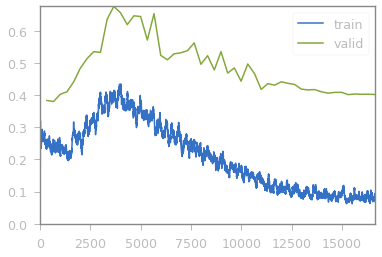

Better model found at epoch 1 with accuracy value: 0.7929482460021973.


In [29]:
learn.fit_one_cycle(50, lr_max = slice(low_lr, lr))

**Loss plot of the baseline:**
    
Due to the high noise in the data, the baseline struggles both in terms of training loss as well as validation loss as the model tends to overfit easily to the noise.

In [30]:
data_test = (ImageDataLoaders.from_df(test_df, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
preds = learn.get_preds(dl=data_test)
preds
print("length of preds[1]",len(preds[1]))
acc= accuracy(preds[0], preds[1])
print(" BaselineTop-1 Accuracy:", acc)

length of preds[1] 3333
 BaselineTop-1 Accuracy: TensorBase(0.8530)


 ------------
 B0|Epochs|20|8056   |
 -----------------------------

In [31]:
err = {}
acc = []
log_preds, y  = learn.tta(dl=data_test)
tta_acc = accuracy(log_preds, y)
print(tta_acc)
err[0] = (100.0, 100.0*(1.0-float(tta_acc)))
acc.append(tta_acc)

TensorBase(0.8620)


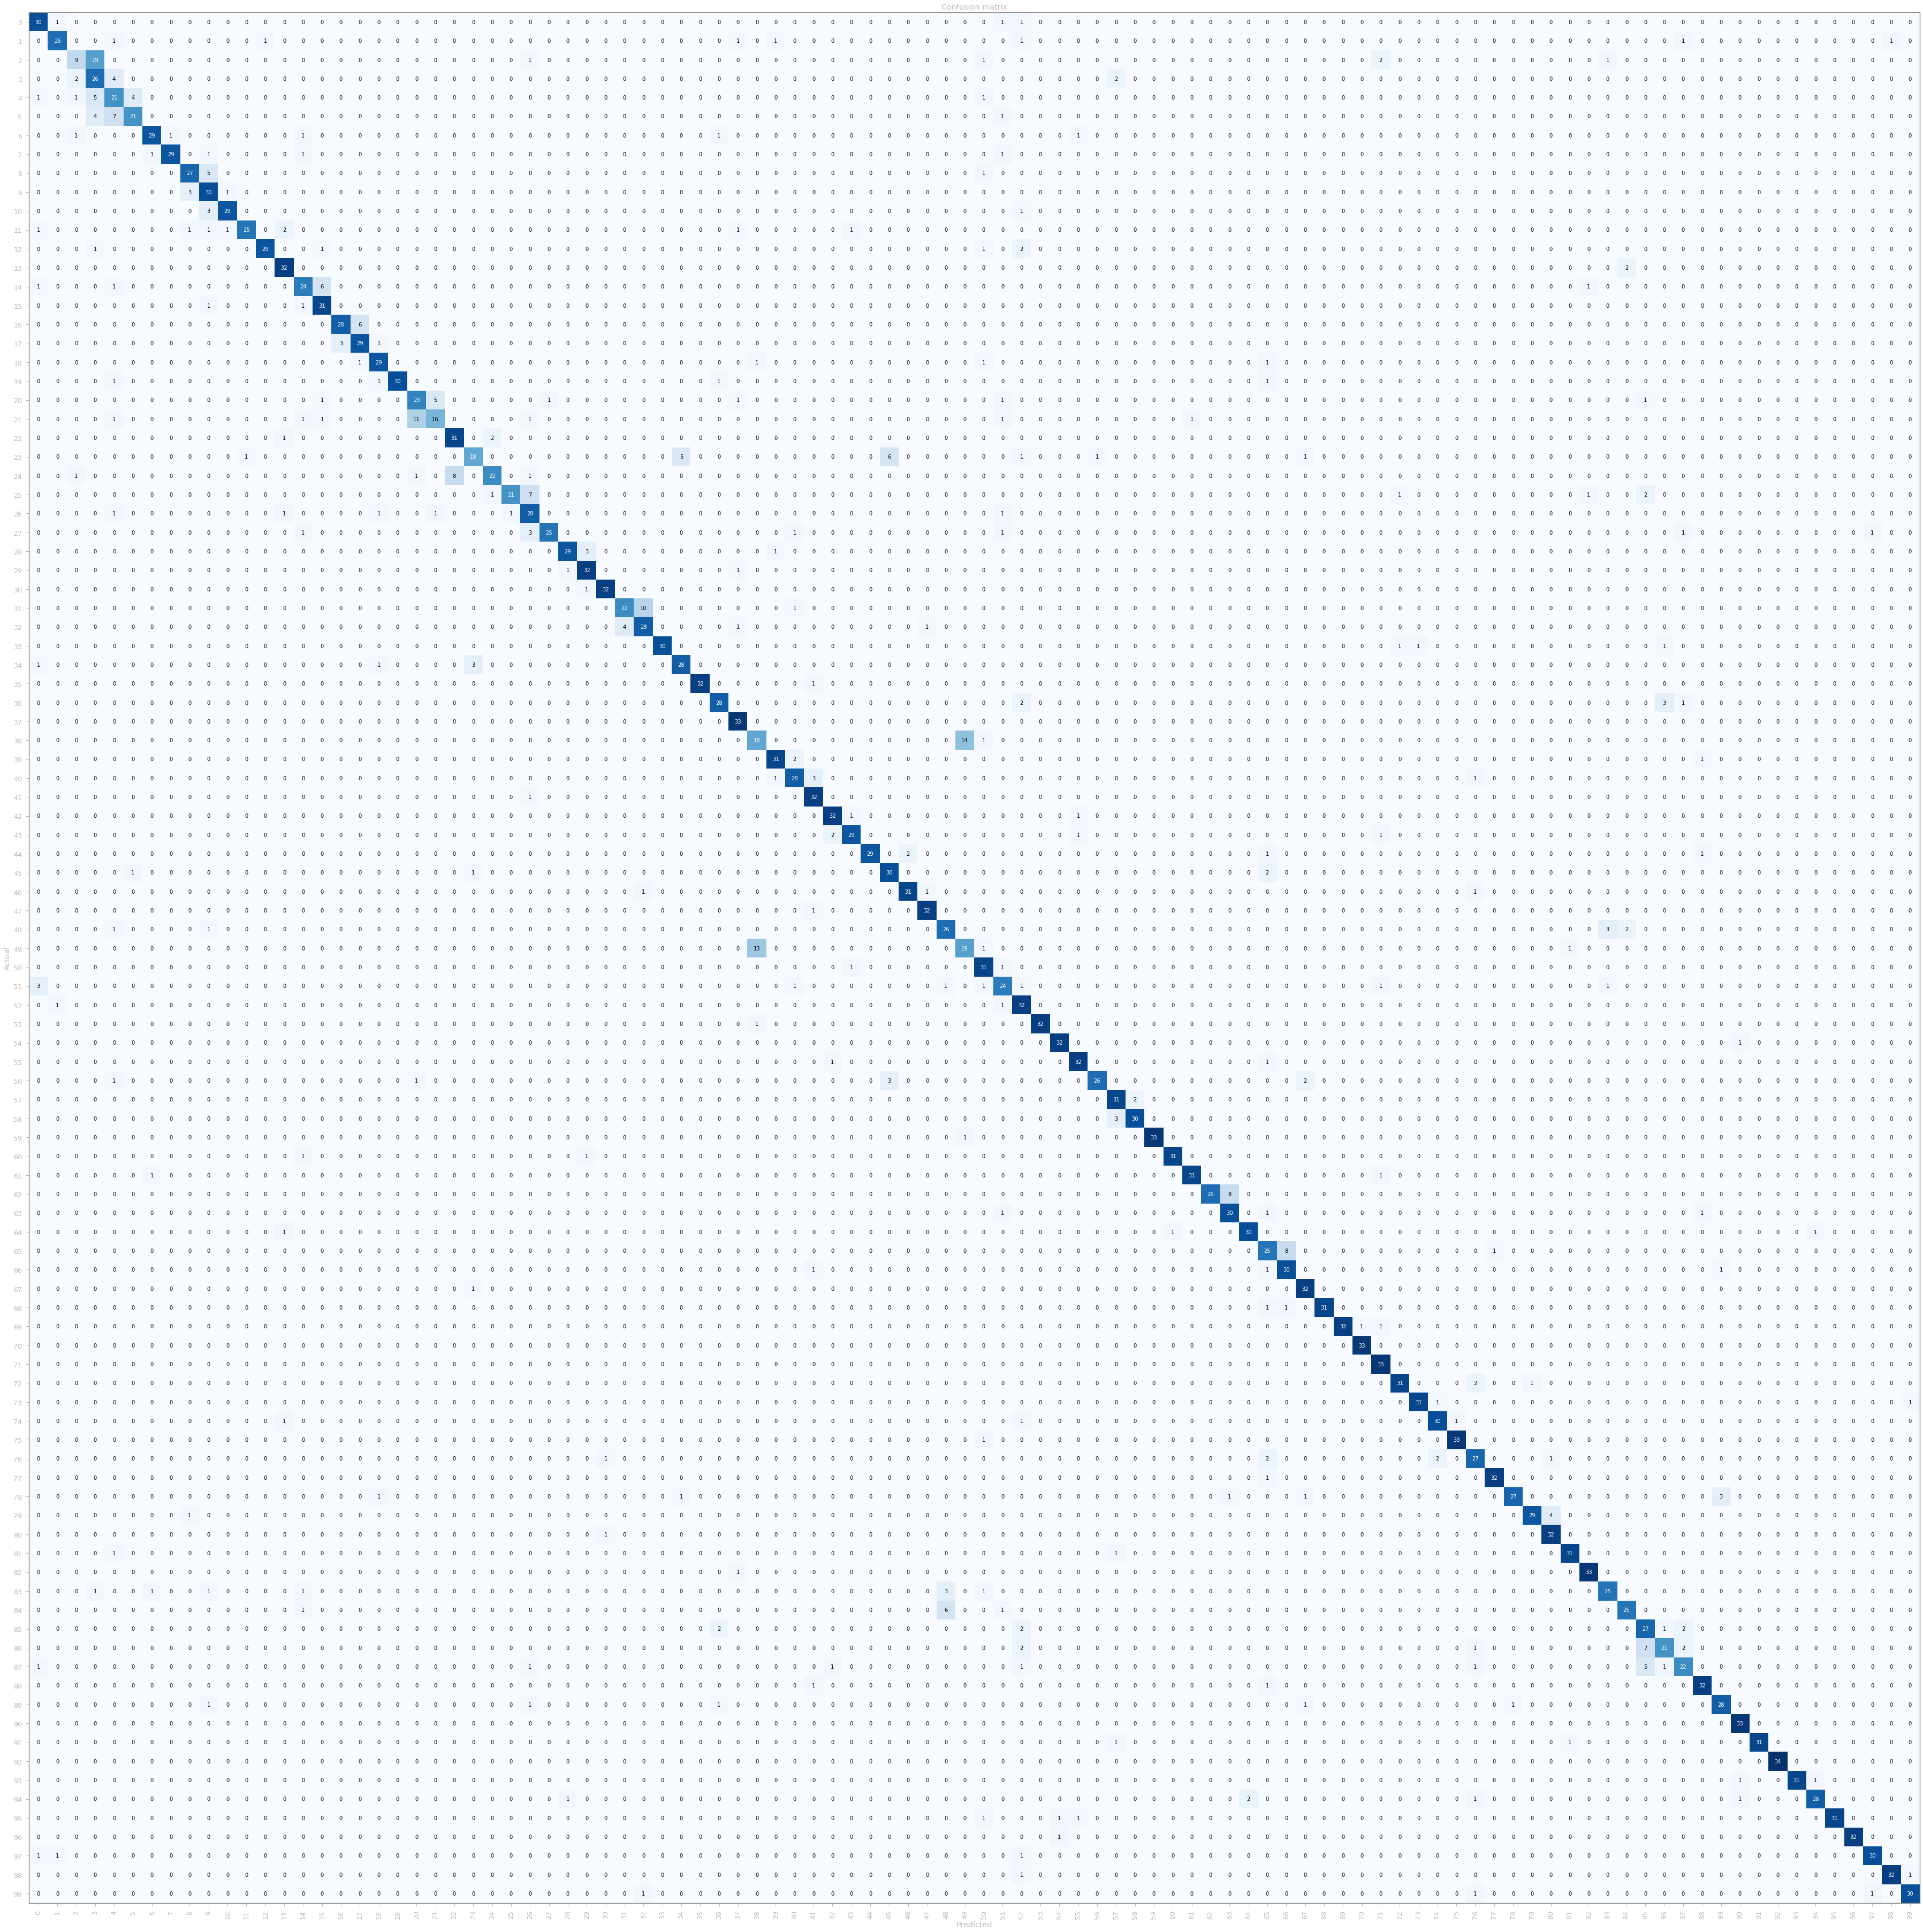

In [32]:
inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
inter_test.plot_confusion_matrix(figsize = (50,50))

In [33]:
PATH='models/'+feature_path+'.p'
torch.save(model.state_dict(), PATH)

In [34]:
# import shutil
import os
# Specify the path of the folder where you want to create the directory
folder_path = 'models'

# Specify the name of the directory you want to create
directory_name = 'baseline'

# Combine the folder path and directory name
new_directory_path = os.path.join(folder_path, directory_name)

# Create the directory
try:
    # Create the directory
    os.makedirs(new_directory_path)
    print(f"Directory '{directory_name}' created inside '{folder_path}'.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists inside '{folder_path}'.")

# Now, here we copy the best model for baseline and past into the destination, like the folder we created inside the model directory, named "baseline"!!!!!
source = 'models/'+best_pth+'.pth'

destination = 'models/baseline/'+best_pth+'.pth'
# Copy the file from source to destination
shutil.copy(source, destination)

Directory 'baseline' already exists inside 'models'.


'models/baseline/gce_aircrafts_asym_0.1_baseline.pth'

In [35]:
drop_idxx = []
los = []
top_losses = []
k_samples = 100       # Number of samples for top losses filtering

def class_frequencies(data,class_key='Label'):
    classes = set(data[class_key])
    class_freq = {}
    max_freq = 0.5
    min_freq =100000#1000000
    for cl in classes:
        class_df = data[data[class_key]==cl]
        freq = len(class_df)
        max_freq = max(freq,max_freq)
        min_freq = min(freq,min_freq)
        class_freq[cl] = freq
        #print(f'Frequency of class {cl}: {class_freq[cl]} ')
    print(f'Max frequency is {max_freq}')
    print(f'Min frequency is {min_freq}')
    return class_freq,max_freq,min_freq
    

def russian_roulette(idx, losses, data,class_key='Label', min_prob=0.5,max_prob=0.9): #min_prob=0.5,max_prob=0.9 original values
    
    class_freq,max_freq,min_freq = class_frequencies(data,class_key)
    min_prob = float(min_freq/max_freq)*max_prob
    print(f'Min probability = {min_prob}')
    deltap = (max_prob - min_prob)/(max_freq**2)
    drop_idx = []
    for n,i in enumerate(idx.numpy()):
        l = data.iloc[i][class_key]
        prob = min_prob + (class_freq[l]-min_freq)*deltap
        r = rn.random()
        if  r < prob:
            drop_idx.append(i)
            class_freq[l] -= 1 
    return drop_idx

def data_definition(data,imgs,tfms,model,best_pth,k_samples=k_samples, min_prob=0.4, max_prob = 0.9, largest=True): # k_sample = 1000
    databunch = ( ImageDataLoaders.from_df(data, valid_pct=0.0, bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))
    learn_cln = (learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func, cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
    learn_cln.load(best_pth)
    entire_training_set_csv0 = (ImageDataLoaders.from_df(data, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
    interp = ClassificationInterpretation.from_learner(learn_cln, dl = entire_training_set_csv0)
    losses = None
    idx = None
    if hybrid:
        l_big,idx_big = interp.top_losses(k_samples//2,largest=True)
        l_sm,idx_sm = interp.top_losses(k_samples//2,largest=False)
        losses = torch.cat((l_big,l_sm),0)
        idx = torch.cat((idx_big,idx_sm),0)
    else:
        losses,idx = interp.top_losses(k_samples,largest=largest)
    drop_idx = russian_roulette(idx,losses,data,min_prob = min_prob, max_prob = max_prob)
    data_filtered = data.drop(data.index[drop_idx])
    print(f'Dropped {len(drop_idx)} top losses')
    return data_filtered

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 40 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6627


epoch,train_loss,valid_loss,accuracy,time
0,0.275122,0.206500,0.889811,01:51


Better model found at epoch 0 with accuracy value: 0.8898113369941711.


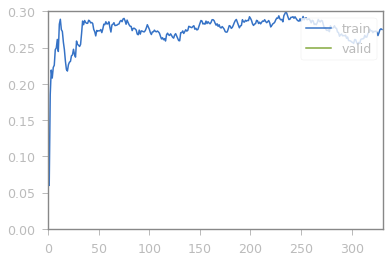

************Round:  0
TTA Accuracy:0.8661866188049316
cycle 0 Error Rate is [{0: (0.5999700014999276, 13.381338119506836)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 40 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6587


epoch,train_loss,valid_loss,accuracy,time
0,0.247991,0.209019,0.891420,01:47


Better model found at epoch 0 with accuracy value: 0.8914198875427246.


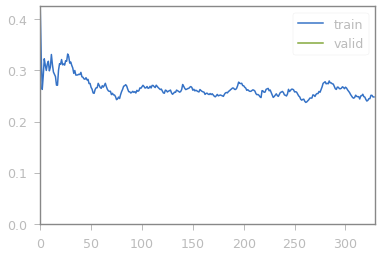

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 48 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6539


epoch,train_loss,valid_loss,accuracy,time
0,0.262172,0.204892,0.892884,01:47


Better model found at epoch 0 with accuracy value: 0.8928844928741455.


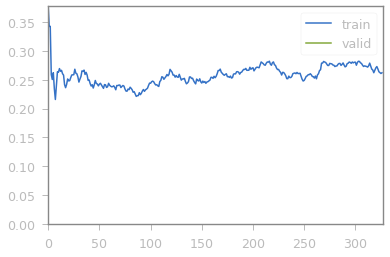

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 40 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6499


epoch,train_loss,valid_loss,accuracy,time
0,0.234256,0.208113,0.892225,01:47


Better model found at epoch 0 with accuracy value: 0.8922247886657715.


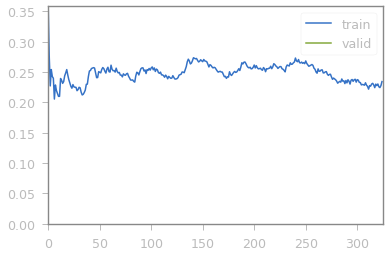

************Round:  3
TTA Accuracy:0.8721871972084045
cycle 0 Error Rate is [{0: (0.5999700014999276, 13.381338119506836), 3: (2.5198740062996827, 12.781280279159546)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 34 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6465


epoch,train_loss,valid_loss,accuracy,time
0,0.241983,0.196331,0.898685,01:46


Better model found at epoch 0 with accuracy value: 0.8986852169036865.


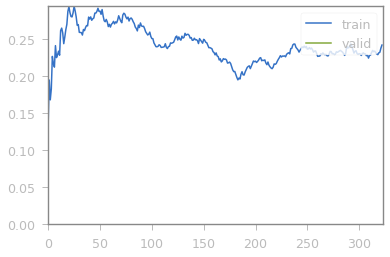

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 32 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6433


epoch,train_loss,valid_loss,accuracy,time
0,0.252074,0.178164,0.904355,01:46


Better model found at epoch 0 with accuracy value: 0.9043545722961426.


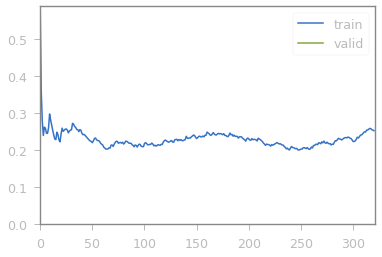

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 37 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6396


epoch,train_loss,valid_loss,accuracy,time
0,0.218102,0.197572,0.899922,01:47


Better model found at epoch 0 with accuracy value: 0.8999218344688416.


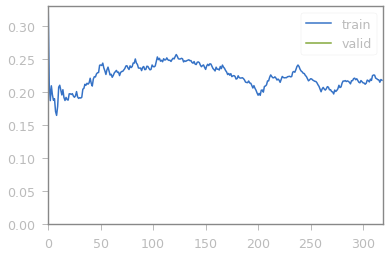

************Round:  6
TTA Accuracy:0.8799880146980286
cycle 0 Error Rate is [{0: (0.5999700014999276, 13.381338119506836), 3: (2.5198740062996827, 12.781280279159546), 6: (4.064796760161993, 12.001198530197144)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 36 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6360


epoch,train_loss,valid_loss,accuracy,time
0,0.220163,0.177935,0.904874,01:46


Better model found at epoch 0 with accuracy value: 0.9048742055892944.


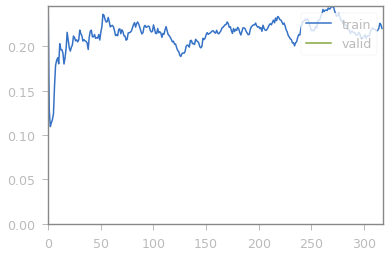

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 33 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6327


epoch,train_loss,valid_loss,accuracy,time
0,0.214640,0.175877,0.909091,01:44


Better model found at epoch 0 with accuracy value: 0.9090909361839294.


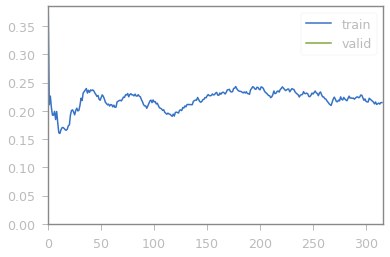

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 37 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6290


epoch,train_loss,valid_loss,accuracy,time
0,0.216130,0.162554,0.914149,01:45


Better model found at epoch 0 with accuracy value: 0.9141494631767273.


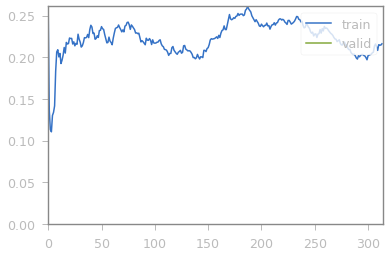

************Round:  9
TTA Accuracy:0.8736873865127563
cycle 0 Error Rate is [{0: (0.5999700014999276, 13.381338119506836), 3: (2.5198740062996827, 12.781280279159546), 6: (4.064796760161993, 12.001198530197144), 9: (5.654717264136789, 12.631261348724365)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 30 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6260


epoch,train_loss,valid_loss,accuracy,time
0,0.236314,0.145999,0.920927,01:44


Better model found at epoch 0 with accuracy value: 0.9209265112876892.


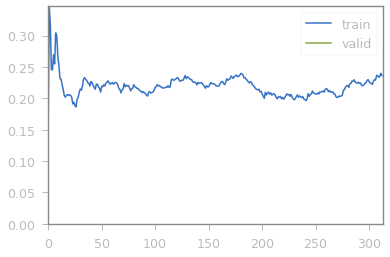

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 33 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6227


epoch,train_loss,valid_loss,accuracy,time
0,0.209100,0.158151,0.917269,01:42


Better model found at epoch 0 with accuracy value: 0.9172690510749817.


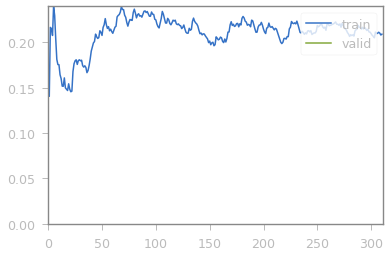

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 26 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6201


epoch,train_loss,valid_loss,accuracy,time
0,0.224274,0.167282,0.914516,01:42


Better model found at epoch 0 with accuracy value: 0.9145161509513855.


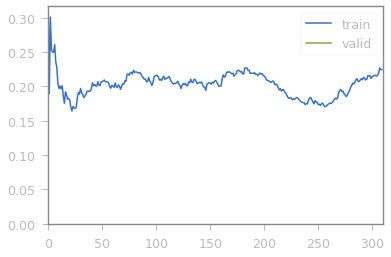

************Round:  12
TTA Accuracy:0.8781878352165222
cycle 0 Error Rate is [{0: (0.5999700014999276, 13.381338119506836), 3: (2.5198740062996827, 12.781280279159546), 6: (4.064796760161993, 12.001198530197144), 9: (5.654717264136789, 12.631261348724365), 12: (6.9896505174741215, 12.181216478347778)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 43
Min probability = 0.5776119402985075
Dropped 24 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6177


epoch,train_loss,valid_loss,accuracy,time
0,0.216205,0.156902,0.922267,01:41


Better model found at epoch 0 with accuracy value: 0.9222671985626221.


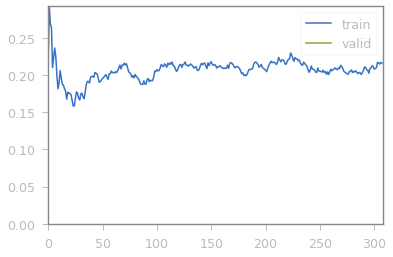

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 43
Min probability = 0.5776119402985075
Dropped 28 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6149


epoch,train_loss,valid_loss,accuracy,time
0,0.193669,0.151682,0.922701,01:40


Better model found at epoch 0 with accuracy value: 0.922701358795166.


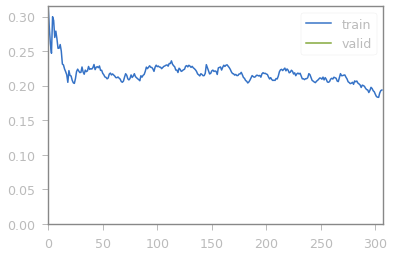

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 46 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6621


epoch,train_loss,valid_loss,accuracy,time
0,0.211498,0.167314,0.915408,01:50


Better model found at epoch 0 with accuracy value: 0.9154078364372253.


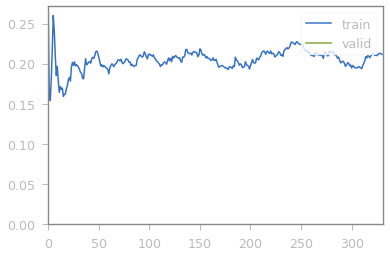

************Round:  0
TTA Accuracy:0.8784878253936768
cycle 1 Error Rate is [{0: (0.5999700014999276, 13.381338119506836), 3: (2.5198740062996827, 12.781280279159546), 6: (4.064796760161993, 12.001198530197144), 9: (5.654717264136789, 12.631261348724365), 12: (6.9896505174741215, 12.181216478347778), 15: (0.6899655017249096, 12.151217460632324)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 41 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6580


epoch,train_loss,valid_loss,accuracy,time
0,0.206639,0.160410,0.917173,01:48


Better model found at epoch 0 with accuracy value: 0.9171732664108276.


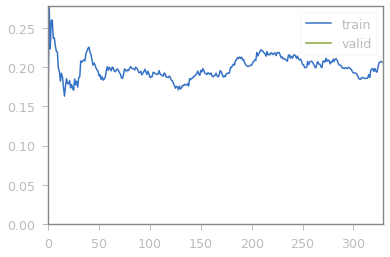

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 43 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6537


epoch,train_loss,valid_loss,accuracy,time
0,0.196939,0.176197,0.910482,01:47


Better model found at epoch 0 with accuracy value: 0.9104820489883423.


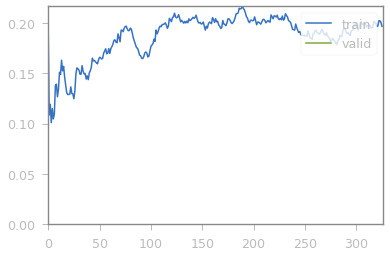

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 38 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6499


epoch,train_loss,valid_loss,accuracy,time
0,0.202106,0.130499,0.931486,01:47


Better model found at epoch 0 with accuracy value: 0.9314857721328735.


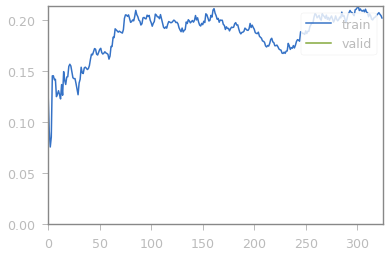

************Round:  3
TTA Accuracy:0.8793879151344299
cycle 1 Error Rate is [{0: (0.5999700014999276, 13.381338119506836), 3: (2.5198740062996827, 12.781280279159546), 6: (4.064796760161993, 12.001198530197144), 9: (5.654717264136789, 12.631261348724365), 12: (6.9896505174741215, 12.181216478347778), 15: (0.6899655017249096, 12.151217460632324), 18: (2.5198740062996827, 12.061208486557007)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 33 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6466


epoch,train_loss,valid_loss,accuracy,time
0,0.198175,0.148377,0.924981,01:47


Better model found at epoch 0 with accuracy value: 0.924980640411377.


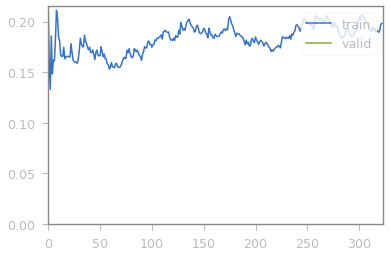

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 39 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6427


epoch,train_loss,valid_loss,accuracy,time
0,0.182228,0.148672,0.921401,01:46


Better model found at epoch 0 with accuracy value: 0.921400785446167.


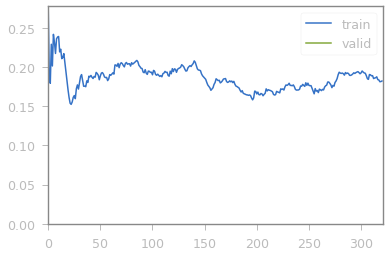

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 37 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6390


epoch,train_loss,valid_loss,accuracy,time
0,0.177497,0.148848,0.924100,01:47


Better model found at epoch 0 with accuracy value: 0.9241001605987549.


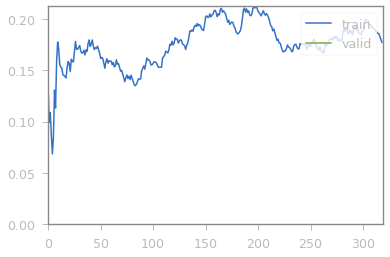

************Round:  6
TTA Accuracy:0.8832883238792419
cycle 1 Error Rate is [{0: (0.5999700014999276, 13.381338119506836), 3: (2.5198740062996827, 12.781280279159546), 6: (4.064796760161993, 12.001198530197144), 9: (5.654717264136789, 12.631261348724365), 12: (6.9896505174741215, 12.181216478347778), 15: (0.6899655017249096, 12.151217460632324), 18: (2.5198740062996827, 12.061208486557007), 21: (4.154792260386985, 11.671167612075806)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 39 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6351


epoch,train_loss,valid_loss,accuracy,time
0,0.176994,0.141949,0.924409,01:44


Better model found at epoch 0 with accuracy value: 0.9244094491004944.


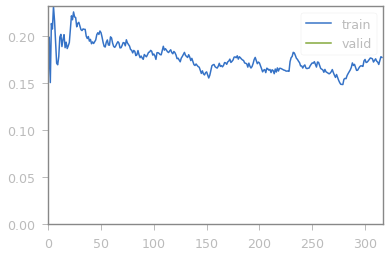

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 33 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6318


epoch,train_loss,valid_loss,accuracy,time
0,0.173649,0.146238,0.925574,01:43


Better model found at epoch 0 with accuracy value: 0.925574004650116.


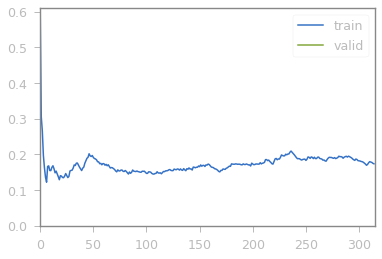

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 50
Min probability = 0.6716417910447762
Dropped 31 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6287


epoch,train_loss,valid_loss,accuracy,time
0,0.199618,0.133666,0.929196,01:43


Better model found at epoch 0 with accuracy value: 0.9291964769363403.


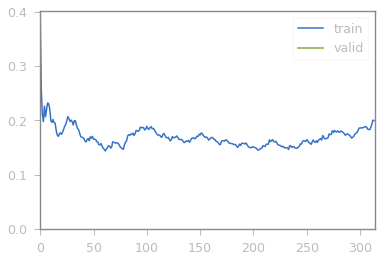

************Round:  9
TTA Accuracy:0.8799880146980286
cycle 1 Error Rate is [{0: (0.5999700014999276, 13.381338119506836), 3: (2.5198740062996827, 12.781280279159546), 6: (4.064796760161993, 12.001198530197144), 9: (5.654717264136789, 12.631261348724365), 12: (6.9896505174741215, 12.181216478347778), 15: (0.6899655017249096, 12.151217460632324), 18: (2.5198740062996827, 12.061208486557007), 21: (4.154792260386985, 11.671167612075806), 24: (5.699715014249285, 12.001198530197144)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 38 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6249


epoch,train_loss,valid_loss,accuracy,time
0,0.170966,0.128396,0.933547,01:42


Better model found at epoch 0 with accuracy value: 0.9335468411445618.


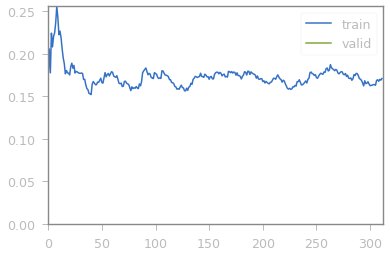

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 38 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6211


epoch,train_loss,valid_loss,accuracy,time
0,0.178064,0.140741,0.925926,01:42


Better model found at epoch 0 with accuracy value: 0.9259259104728699.


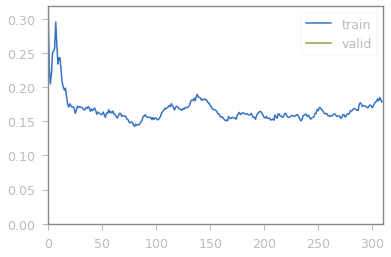

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 32 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6179


epoch,train_loss,valid_loss,accuracy,time
0,0.173270,0.125984,0.936032,01:41


Better model found at epoch 0 with accuracy value: 0.9360324144363403.


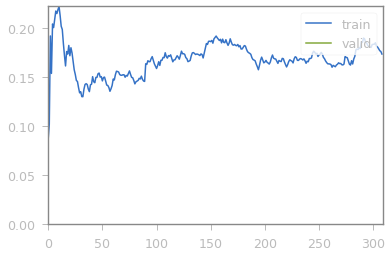

************Round:  12
TTA Accuracy:0.8784878253936768
cycle 1 Error Rate is [{0: (0.5999700014999276, 13.381338119506836), 3: (2.5198740062996827, 12.781280279159546), 6: (4.064796760161993, 12.001198530197144), 9: (5.654717264136789, 12.631261348724365), 12: (6.9896505174741215, 12.181216478347778), 15: (0.6899655017249096, 12.151217460632324), 18: (2.5198740062996827, 12.061208486557007), 21: (4.154792260386985, 11.671167612075806), 24: (5.699715014249285, 12.001198530197144), 27: (7.319634018299082, 12.151217460632324)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 27 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6152


epoch,train_loss,valid_loss,accuracy,time
0,0.183968,0.128329,0.934146,01:41


Better model found at epoch 0 with accuracy value: 0.9341463446617126.


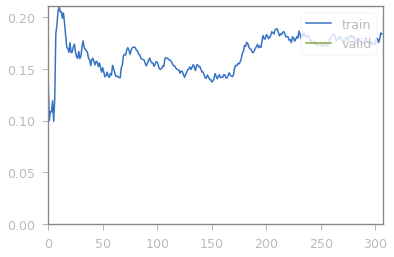

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 31 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6121


epoch,train_loss,valid_loss,accuracy,time
0,0.163772,0.141053,0.930556,01:41


Better model found at epoch 0 with accuracy value: 0.9305555820465088.


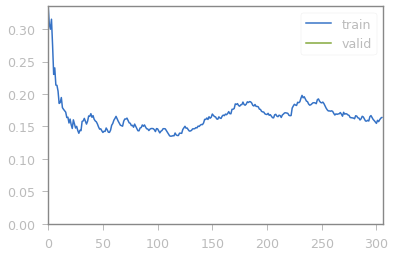

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 44 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6623


epoch,train_loss,valid_loss,accuracy,time
0,0.156908,0.126035,0.937311,01:49


Better model found at epoch 0 with accuracy value: 0.9373111724853516.


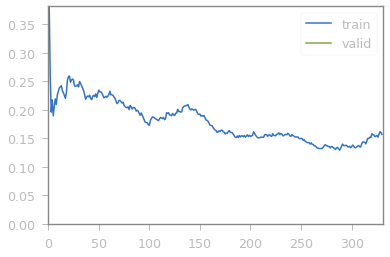

************Round:  0
TTA Accuracy:0.8793879151344299
cycle 2 Error Rate is [{0: (0.5999700014999276, 13.381338119506836), 3: (2.5198740062996827, 12.781280279159546), 6: (4.064796760161993, 12.001198530197144), 9: (5.654717264136789, 12.631261348724365), 12: (6.9896505174741215, 12.181216478347778), 15: (0.6899655017249096, 12.151217460632324), 18: (2.5198740062996827, 12.061208486557007), 21: (4.154792260386985, 11.671167612075806), 24: (5.699715014249285, 12.001198530197144), 27: (7.319634018299082, 12.151217460632324), 30: (0.6599670016499193, 12.061208486557007)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 41 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6582


epoch,train_loss,valid_loss,accuracy,time
0,0.152351,0.122953,0.937690,01:48


Better model found at epoch 0 with accuracy value: 0.9376899600028992.


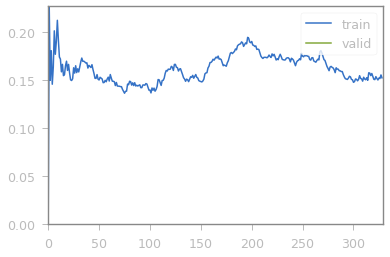

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 40 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6542


epoch,train_loss,valid_loss,accuracy,time
0,0.154322,0.129361,0.932722,01:47


Better model found at epoch 0 with accuracy value: 0.932721734046936.


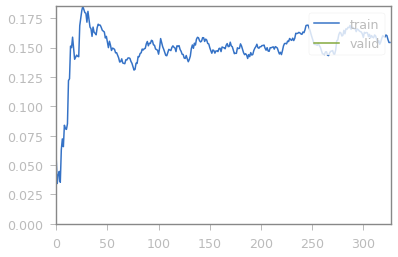

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 46 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6496


epoch,train_loss,valid_loss,accuracy,time
0,0.159443,0.126597,0.936105,01:46


Better model found at epoch 0 with accuracy value: 0.9361047148704529.


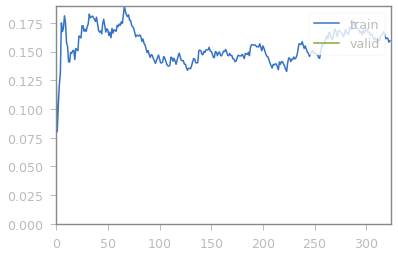

************Round:  3
TTA Accuracy:0.8787878751754761
cycle 2 Error Rate is [{0: (0.5999700014999276, 13.381338119506836), 3: (2.5198740062996827, 12.781280279159546), 6: (4.064796760161993, 12.001198530197144), 9: (5.654717264136789, 12.631261348724365), 12: (6.9896505174741215, 12.181216478347778), 15: (0.6899655017249096, 12.151217460632324), 18: (2.5198740062996827, 12.061208486557007), 21: (4.154792260386985, 11.671167612075806), 24: (5.699715014249285, 12.001198530197144), 27: (7.319634018299082, 12.151217460632324), 30: (0.6599670016499193, 12.061208486557007), 33: (2.5648717564121792, 12.121212482452393)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 34 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6462


epoch,train_loss,valid_loss,accuracy,time
0,0.152576,0.111973,0.942724,01:46


Better model found at epoch 0 with accuracy value: 0.9427244663238525.


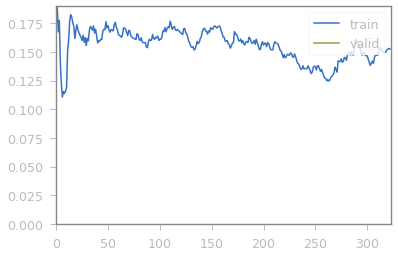

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 32 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6430


epoch,train_loss,valid_loss,accuracy,time
0,0.132589,0.125309,0.937014,01:45


Better model found at epoch 0 with accuracy value: 0.9370139837265015.


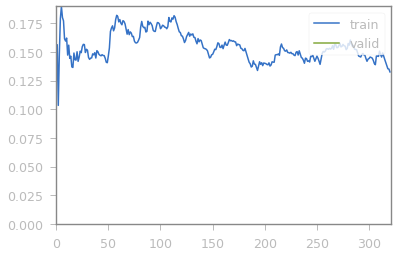

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 36 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6394


epoch,train_loss,valid_loss,accuracy,time
0,0.143252,0.114507,0.941315,01:45


Better model found at epoch 0 with accuracy value: 0.9413145780563354.


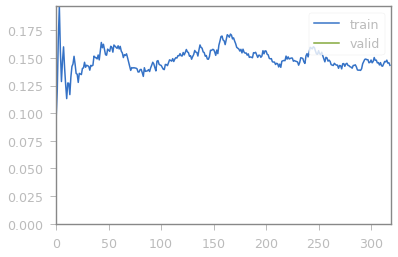

************Round:  6
TTA Accuracy:0.8799880146980286
cycle 2 Error Rate is [{0: (0.5999700014999276, 13.381338119506836), 3: (2.5198740062996827, 12.781280279159546), 6: (4.064796760161993, 12.001198530197144), 9: (5.654717264136789, 12.631261348724365), 12: (6.9896505174741215, 12.181216478347778), 15: (0.6899655017249096, 12.151217460632324), 18: (2.5198740062996827, 12.061208486557007), 21: (4.154792260386985, 11.671167612075806), 24: (5.699715014249285, 12.001198530197144), 27: (7.319634018299082, 12.151217460632324), 30: (0.6599670016499193, 12.061208486557007), 33: (2.5648717564121792, 12.121212482452393), 36: (4.0947952602369835, 12.001198530197144)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 36 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6358


epoch,train_loss,valid_loss,accuracy,time
0,0.136802,0.127177,0.934697,01:45


Better model found at epoch 0 with accuracy value: 0.9346970915794373.


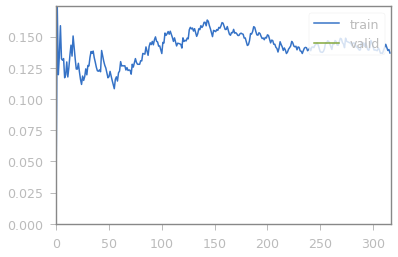

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 35 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6323


epoch,train_loss,valid_loss,accuracy,time
0,0.158817,0.109462,0.943038,01:44


Better model found at epoch 0 with accuracy value: 0.9430379867553711.


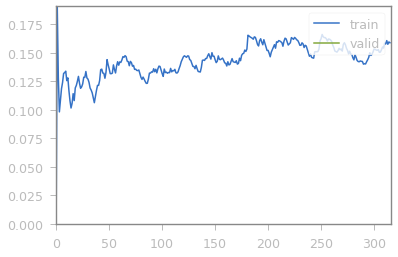

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 31 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6292


epoch,train_loss,valid_loss,accuracy,time
0,0.148712,0.106957,0.945151,01:43


Better model found at epoch 0 with accuracy value: 0.9451510310173035.


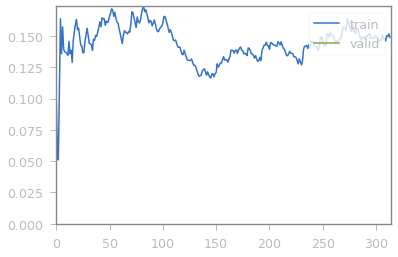

************Round:  9
TTA Accuracy:0.8811880946159363
cycle 2 Error Rate is [{0: (0.5999700014999276, 13.381338119506836), 3: (2.5198740062996827, 12.781280279159546), 6: (4.064796760161993, 12.001198530197144), 9: (5.654717264136789, 12.631261348724365), 12: (6.9896505174741215, 12.181216478347778), 15: (0.6899655017249096, 12.151217460632324), 18: (2.5198740062996827, 12.061208486557007), 21: (4.154792260386985, 11.671167612075806), 24: (5.699715014249285, 12.001198530197144), 27: (7.319634018299082, 12.151217460632324), 30: (0.6599670016499193, 12.061208486557007), 33: (2.5648717564121792, 12.121212482452393), 36: (4.0947952602369835, 12.001198530197144), 39: (5.624718764061798, 11.881190538406372)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 33 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6259


epoch,train_loss,valid_loss,accuracy,time
0,0.130457,0.112741,0.941647,01:43


Better model found at epoch 0 with accuracy value: 0.9416466951370239.


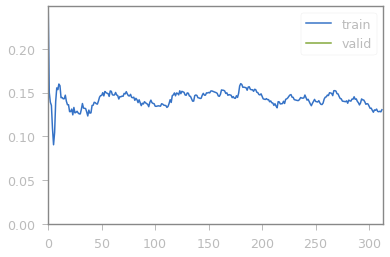

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 50
Min probability = 0.6716417910447762
Dropped 35 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6224


epoch,train_loss,valid_loss,accuracy,time
0,0.142266,0.105027,0.946141,01:43


Better model found at epoch 0 with accuracy value: 0.9461414813995361.


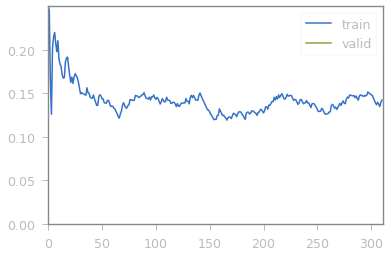

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 38 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6186


epoch,train_loss,valid_loss,accuracy,time
0,0.135468,0.111749,0.941795,01:42


Better model found at epoch 0 with accuracy value: 0.9417946934700012.


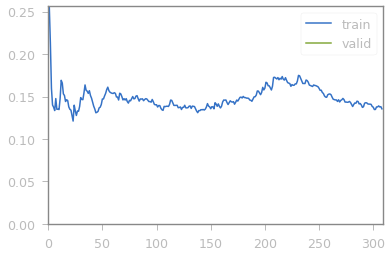

************Round:  12
TTA Accuracy:0.8748874664306641
cycle 2 Error Rate is [{0: (0.5999700014999276, 13.381338119506836), 3: (2.5198740062996827, 12.781280279159546), 6: (4.064796760161993, 12.001198530197144), 9: (5.654717264136789, 12.631261348724365), 12: (6.9896505174741215, 12.181216478347778), 15: (0.6899655017249096, 12.151217460632324), 18: (2.5198740062996827, 12.061208486557007), 21: (4.154792260386985, 11.671167612075806), 24: (5.699715014249285, 12.001198530197144), 27: (7.319634018299082, 12.151217460632324), 30: (0.6599670016499193, 12.061208486557007), 33: (2.5648717564121792, 12.121212482452393), 36: (4.0947952602369835, 12.001198530197144), 39: (5.624718764061798, 11.881190538406372), 42: (7.214639268036594, 12.511253356933594)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 30 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6156


epoch,train_loss,valid_loss,accuracy,time
0,0.127124,0.104405,0.947197,01:41


Better model found at epoch 0 with accuracy value: 0.9471973776817322.


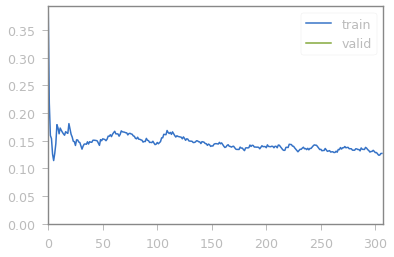

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 31 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6125


epoch,train_loss,valid_loss,accuracy,time
0,0.138353,0.111908,0.942857,01:41


Better model found at epoch 0 with accuracy value: 0.9428571462631226.


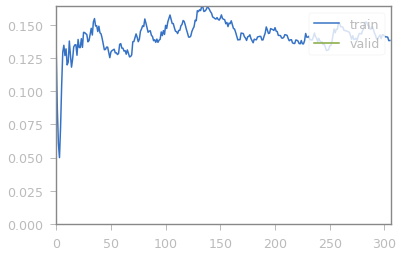

In [36]:
# Define required parameters and lists
n_training_series = 15  # Number of training series for scheme, means iteration in a single cycle
cleaning_cycles = 3   # Number of cleaning cycles for scheme
delta_max = 0.25       # Max delta value for scheme, damping factor value
min_epochs = 1         # number of loop in a single training of series 
min_lr = 1e-4          # for dynamic learning rates, if use.
kappa_lr = 1           # for dynamic learning rates, if use.
min_prob = 0.5         # probability of min classes.
max_prob = 0.9         # probability of max classes.
delta_epochs_per_serie = 0   # change in number of epochs
data_per_serie = {}
data_per_serie[0] = train_df
largest = True
from_scratch = False
hybrid = False
accs = []
deltas = []
err = {}

for c in range(cleaning_cycles):
    for n in range(n_training_series):
        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        loss_func = losses.DampedGCELossFlat(num_classes=num_classes,q=0.5, delta = delta, reduction='mean')      
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))
        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            PATH='models/'+damp_1_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_1_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)     
    

In [37]:
# err = {}
print(err)

{0: (0.5999700014999276, 13.381338119506836), 3: (2.5198740062996827, 12.781280279159546), 6: (4.064796760161993, 12.001198530197144), 9: (5.654717264136789, 12.631261348724365), 12: (6.9896505174741215, 12.181216478347778), 15: (0.6899655017249096, 12.151217460632324), 18: (2.5198740062996827, 12.061208486557007), 21: (4.154792260386985, 11.671167612075806), 24: (5.699715014249285, 12.001198530197144), 27: (7.319634018299082, 12.151217460632324), 30: (0.6599670016499193, 12.061208486557007), 33: (2.5648717564121792, 12.121212482452393), 36: (4.0947952602369835, 12.001198530197144), 39: (5.624718764061798, 11.881190538406372), 42: (7.214639268036594, 12.511253356933594)}


In [38]:
for i in range(len(accs)):
    print(f'acc:{accs[i]}, delta:{deltas[i]}')

acc:0.8661866188049316, delta:0.05197792270443983
acc:0.8721871972084045, delta:0.18578620636934853
acc:0.8799880146980286, delta:0.24863047384206832
acc:0.8736873865127563, delta:0.21650635094610968
acc:0.8781878352165222, delta:0.10168416076895001
acc:0.8784878253936768, delta:0.05197792270443983
acc:0.8793879151344299, delta:0.18578620636934853
acc:0.8832883238792419, delta:0.24863047384206832
acc:0.8799880146980286, delta:0.21650635094610968
acc:0.8784878253936768, delta:0.10168416076895001
acc:0.8793879151344299, delta:0.05197792270443983
acc:0.8787878751754761, delta:0.18578620636934853
acc:0.8799880146980286, delta:0.24863047384206832
acc:0.8811880946159363, delta:0.21650635094610968
acc:0.8748874664306641, delta:0.10168416076895001


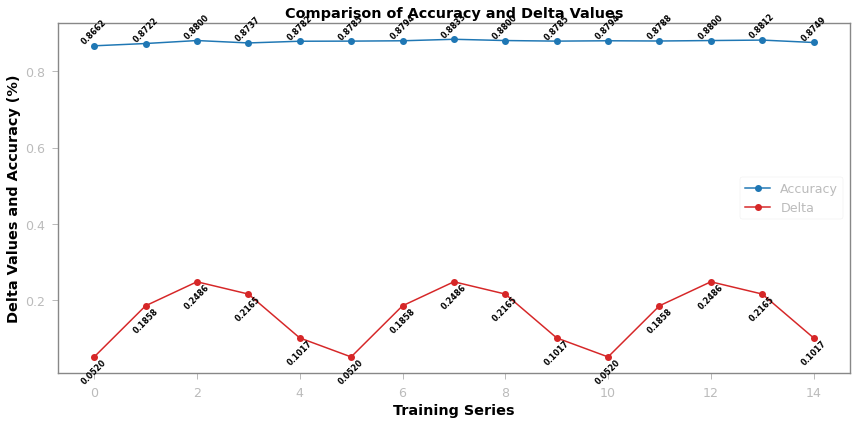

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()


+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 45 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6622


epoch,train_loss,valid_loss,accuracy,time
0,0.133590,0.137428,0.928248,01:48


Better model found at epoch 0 with accuracy value: 0.9282477498054504.


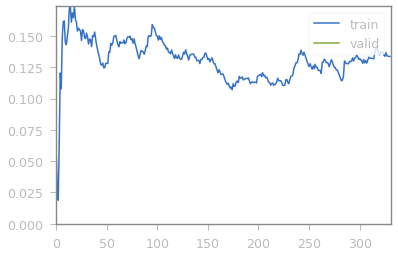

************Round:  0
TTA Accuracy:0.8790879249572754
cycle 0 Error Rate is [{0: (0.6749662516874144, 12.091207504272461)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 40 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6582


epoch,train_loss,valid_loss,accuracy,time
0,0.122004,0.114303,0.940729,01:47


Better model found at epoch 0 with accuracy value: 0.9407294988632202.


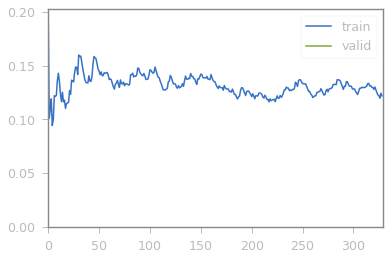

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 44 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6538


epoch,train_loss,valid_loss,accuracy,time
0,0.122115,0.098021,0.947972,01:46


Better model found at epoch 0 with accuracy value: 0.9479724764823914.


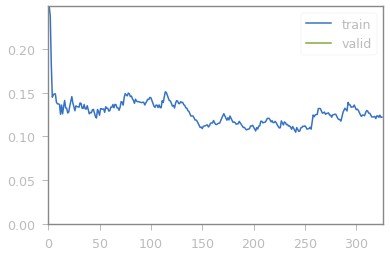

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 42 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6496


epoch,train_loss,valid_loss,accuracy,time
0,0.135030,0.087421,0.954580,01:46


Better model found at epoch 0 with accuracy value: 0.9545804262161255.


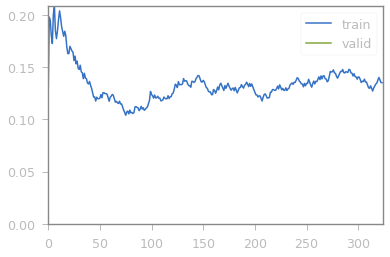

************Round:  3
TTA Accuracy:0.8712871074676514
cycle 0 Error Rate is [{0: (0.6749662516874144, 12.091207504272461), 3: (2.5648717564121792, 12.871289253234863)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 40 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6456


epoch,train_loss,valid_loss,accuracy,time
0,0.126317,0.112532,0.941131,01:45


Better model found at epoch 0 with accuracy value: 0.9411308765411377.


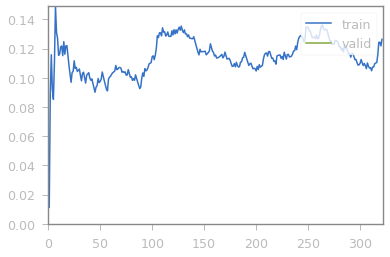

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 38 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6418


epoch,train_loss,valid_loss,accuracy,time
0,0.125322,0.132598,0.932190,01:45


Better model found at epoch 0 with accuracy value: 0.9321901798248291.


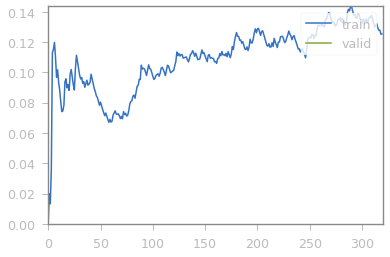

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 41 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6377


epoch,train_loss,valid_loss,accuracy,time
0,0.125089,0.076322,0.961569,01:45


Better model found at epoch 0 with accuracy value: 0.9615686535835266.


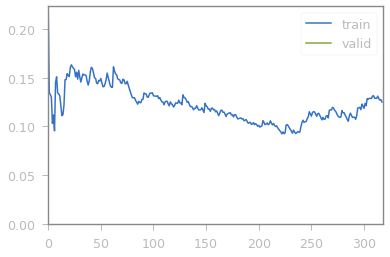

************Round:  6
TTA Accuracy:0.8742874264717102
cycle 0 Error Rate is [{0: (0.6749662516874144, 12.091207504272461), 3: (2.5648717564121792, 12.871289253234863), 6: (4.349782510874456, 12.57125735282898)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 34 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6343


epoch,train_loss,valid_loss,accuracy,time
0,0.118620,0.101861,0.948738,01:44


Better model found at epoch 0 with accuracy value: 0.948738157749176.


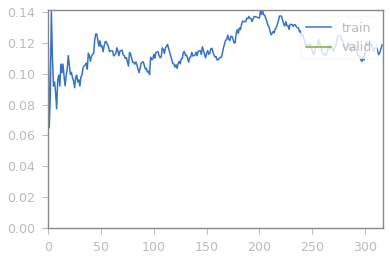

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 29 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6314


epoch,train_loss,valid_loss,accuracy,time
0,0.101750,0.100230,0.948494,01:43


Better model found at epoch 0 with accuracy value: 0.9484944343566895.


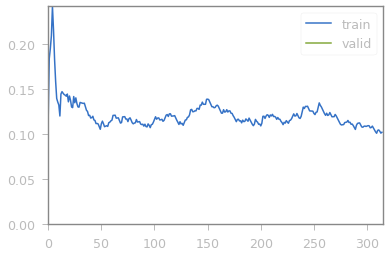

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 34 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6280


epoch,train_loss,valid_loss,accuracy,time
0,0.106649,0.099165,0.949045,01:43


Better model found at epoch 0 with accuracy value: 0.9490445852279663.


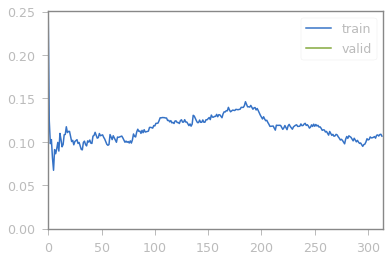

************Round:  9
TTA Accuracy:0.8748874664306641
cycle 0 Error Rate is [{0: (0.6749662516874144, 12.091207504272461), 3: (2.5648717564121792, 12.871289253234863), 6: (4.349782510874456, 12.57125735282898), 9: (5.804709764511773, 12.511253356933594)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 50
Min probability = 0.6716417910447762
Dropped 33 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6247


epoch,train_loss,valid_loss,accuracy,time
0,0.093232,0.101116,0.947958,01:43


Better model found at epoch 0 with accuracy value: 0.9479583501815796.


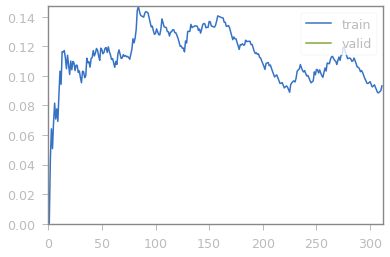

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 50
Min probability = 0.6716417910447762
Dropped 35 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6212


epoch,train_loss,valid_loss,accuracy,time
0,0.114589,0.099578,0.948470,01:41


Better model found at epoch 0 with accuracy value: 0.9484702348709106.


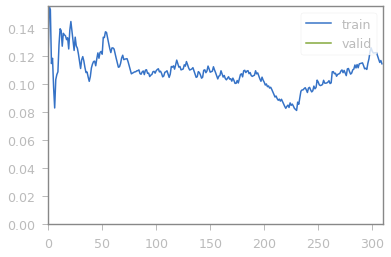

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 34 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6178


epoch,train_loss,valid_loss,accuracy,time
0,0.145341,0.093382,0.953036,01:41


Better model found at epoch 0 with accuracy value: 0.9530364274978638.


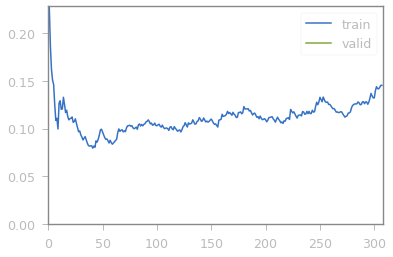

************Round:  12
TTA Accuracy:0.8757875561714172
cycle 0 Error Rate is [{0: (0.6749662516874144, 12.091207504272461), 3: (2.5648717564121792, 12.871289253234863), 6: (4.349782510874456, 12.57125735282898), 9: (5.804709764511773, 12.511253356933594), 12: (7.334633268336588, 12.421244382858276)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 32 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6146


epoch,train_loss,valid_loss,accuracy,time
0,0.113397,0.082025,0.958503,01:41


Better model found at epoch 0 with accuracy value: 0.9585028290748596.


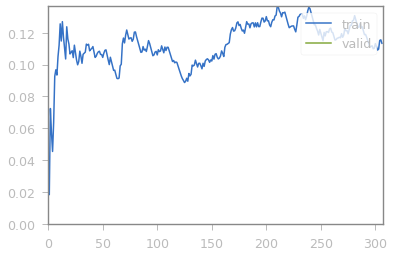

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 35 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6111


epoch,train_loss,valid_loss,accuracy,time
0,0.105108,0.098103,0.949264,01:40


Better model found at epoch 0 with accuracy value: 0.9492635130882263.


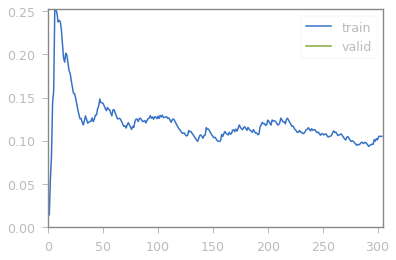

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 42 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6625


epoch,train_loss,valid_loss,accuracy,time
0,0.099380,0.097529,0.950943,01:49


Better model found at epoch 0 with accuracy value: 0.9509434103965759.


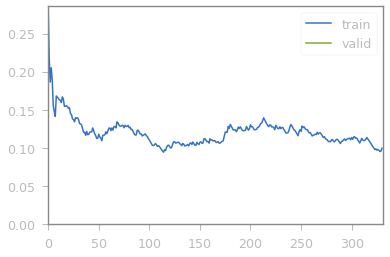

************Round:  0
TTA Accuracy:0.8751875162124634
cycle 1 Error Rate is [{0: (0.6749662516874144, 12.091207504272461), 3: (2.5648717564121792, 12.871289253234863), 6: (4.349782510874456, 12.57125735282898), 9: (5.804709764511773, 12.511253356933594), 12: (7.334633268336588, 12.421244382858276), 15: (0.6299685015749179, 12.481248378753662)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 42 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6583


epoch,train_loss,valid_loss,accuracy,time
0,0.112172,0.096287,0.951368,01:48


Better model found at epoch 0 with accuracy value: 0.9513677954673767.


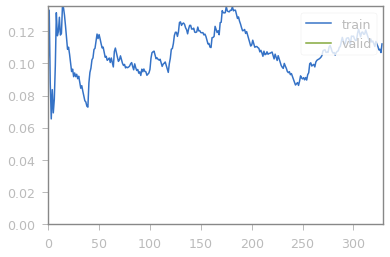

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 38 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6545


epoch,train_loss,valid_loss,accuracy,time
0,0.098045,0.109059,0.944232,01:47


Better model found at epoch 0 with accuracy value: 0.9442322254180908.


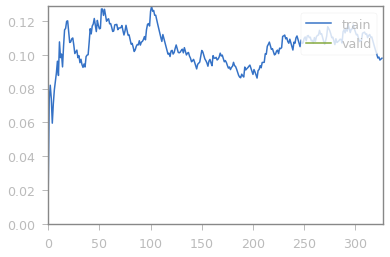

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 37 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6508


epoch,train_loss,valid_loss,accuracy,time
0,0.108080,0.089579,0.954650,01:46


Better model found at epoch 0 with accuracy value: 0.9546502828598022.


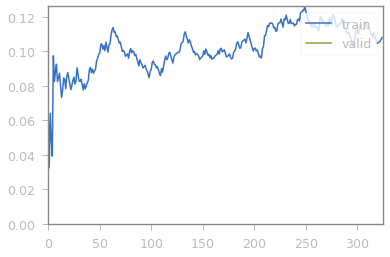

************Round:  3
TTA Accuracy:0.8706870675086975
cycle 1 Error Rate is [{0: (0.6749662516874144, 12.091207504272461), 3: (2.5648717564121792, 12.871289253234863), 6: (4.349782510874456, 12.57125735282898), 9: (5.804709764511773, 12.511253356933594), 12: (7.334633268336588, 12.421244382858276), 15: (0.6299685015749179, 12.481248378753662), 18: (2.3848807559622043, 12.931293249130249)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 40 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6468


epoch,train_loss,valid_loss,accuracy,time
0,0.117086,0.088619,0.954370,01:46


Better model found at epoch 0 with accuracy value: 0.9543696641921997.


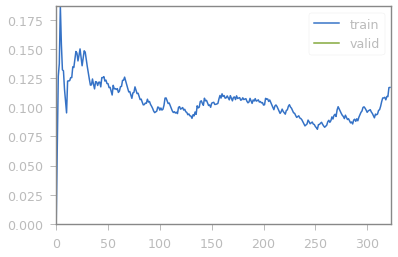

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 34 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6434


epoch,train_loss,valid_loss,accuracy,time
0,0.106646,0.083283,0.958009,01:45


Better model found at epoch 0 with accuracy value: 0.9580093026161194.


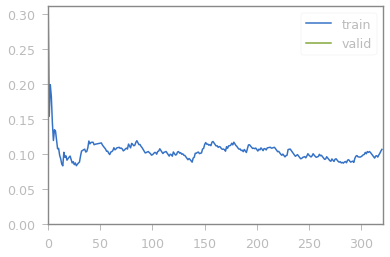

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 39 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6395


epoch,train_loss,valid_loss,accuracy,time
0,0.108852,0.094549,0.953088,01:44


Better model found at epoch 0 with accuracy value: 0.9530883431434631.


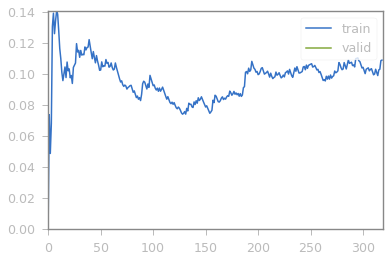

************Round:  6
TTA Accuracy:0.8703870177268982
cycle 1 Error Rate is [{0: (0.6749662516874144, 12.091207504272461), 3: (2.5648717564121792, 12.871289253234863), 6: (4.349782510874456, 12.57125735282898), 9: (5.804709764511773, 12.511253356933594), 12: (7.334633268336588, 12.421244382858276), 15: (0.6299685015749179, 12.481248378753662), 18: (2.3848807559622043, 12.931293249130249), 21: (4.0797960101994875, 12.96129822731018)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 36 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6359


epoch,train_loss,valid_loss,accuracy,time
0,0.101717,0.090668,0.953580,01:44


Better model found at epoch 0 with accuracy value: 0.953579843044281.


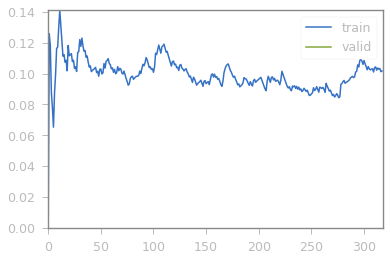

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 32 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6327


epoch,train_loss,valid_loss,accuracy,time
0,0.105849,0.078785,0.958893,01:45


Better model found at epoch 0 with accuracy value: 0.9588932991027832.


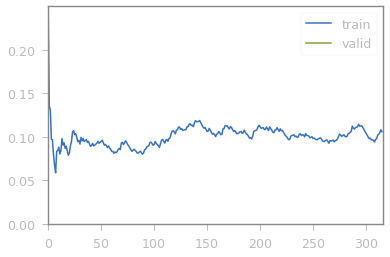

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 32 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6295


epoch,train_loss,valid_loss,accuracy,time
0,0.094010,0.083251,0.956315,01:44


Better model found at epoch 0 with accuracy value: 0.9563145637512207.


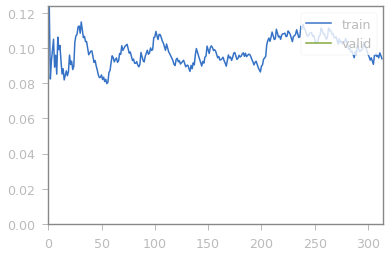

************Round:  9
TTA Accuracy:0.8652865290641785
cycle 1 Error Rate is [{0: (0.6749662516874144, 12.091207504272461), 3: (2.5648717564121792, 12.871289253234863), 6: (4.349782510874456, 12.57125735282898), 9: (5.804709764511773, 12.511253356933594), 12: (7.334633268336588, 12.421244382858276), 15: (0.6299685015749179, 12.481248378753662), 18: (2.3848807559622043, 12.931293249130249), 21: (4.0797960101994875, 12.96129822731018), 24: (5.579721013949301, 13.471347093582153)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 35 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6260


epoch,train_loss,valid_loss,accuracy,time
0,0.100905,0.076443,0.960064,01:44


Better model found at epoch 0 with accuracy value: 0.9600638747215271.


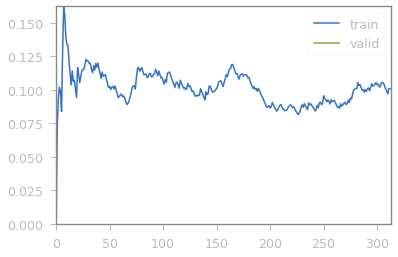

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 34 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6226


epoch,train_loss,valid_loss,accuracy,time
0,0.107862,0.072762,0.962249,01:43


Better model found at epoch 0 with accuracy value: 0.9622489809989929.


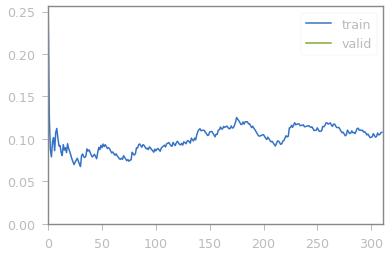

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 40 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6186


epoch,train_loss,valid_loss,accuracy,time
0,0.095838,0.088349,0.953921,01:42


Better model found at epoch 0 with accuracy value: 0.9539207816123962.


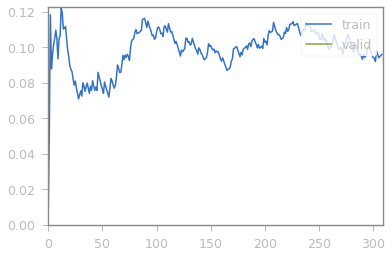

************Round:  12
TTA Accuracy:0.8730872869491577
cycle 1 Error Rate is [{0: (0.6749662516874144, 12.091207504272461), 3: (2.5648717564121792, 12.871289253234863), 6: (4.349782510874456, 12.57125735282898), 9: (5.804709764511773, 12.511253356933594), 12: (7.334633268336588, 12.421244382858276), 15: (0.6299685015749179, 12.481248378753662), 18: (2.3848807559622043, 12.931293249130249), 21: (4.0797960101994875, 12.96129822731018), 24: (5.579721013949301, 13.471347093582153), 27: (7.214639268036594, 12.691271305084229)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 33 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6153


epoch,train_loss,valid_loss,accuracy,time
0,0.104608,0.067502,0.965041,01:41


Better model found at epoch 0 with accuracy value: 0.9650406241416931.


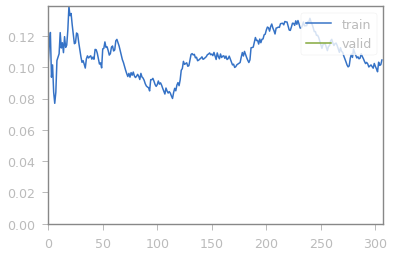

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 50
Min probability = 0.6716417910447762
Dropped 41 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6112


epoch,train_loss,valid_loss,accuracy,time
0,0.115023,0.081006,0.959902,01:41


Better model found at epoch 0 with accuracy value: 0.9599018096923828.


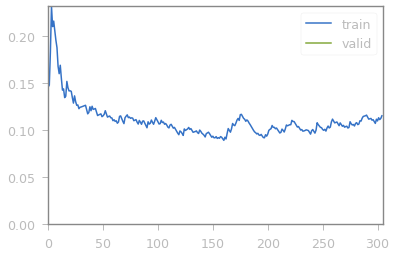

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 41 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6626


epoch,train_loss,valid_loss,accuracy,time
0,0.094139,0.080989,0.958491,01:49


Better model found at epoch 0 with accuracy value: 0.9584905505180359.


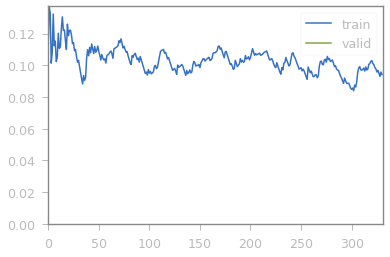

************Round:  0
TTA Accuracy:0.8727872967720032
cycle 2 Error Rate is [{0: (0.6749662516874144, 12.091207504272461), 3: (2.5648717564121792, 12.871289253234863), 6: (4.349782510874456, 12.57125735282898), 9: (5.804709764511773, 12.511253356933594), 12: (7.334633268336588, 12.421244382858276), 15: (0.6299685015749179, 12.481248378753662), 18: (2.3848807559622043, 12.931293249130249), 21: (4.0797960101994875, 12.96129822731018), 24: (5.579721013949301, 13.471347093582153), 27: (7.214639268036594, 12.691271305084229), 30: (0.6149692515374228, 12.721270322799683)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 44 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6582


epoch,train_loss,valid_loss,accuracy,time
0,0.093875,0.098967,0.949848,01:49


Better model found at epoch 0 with accuracy value: 0.9498479962348938.


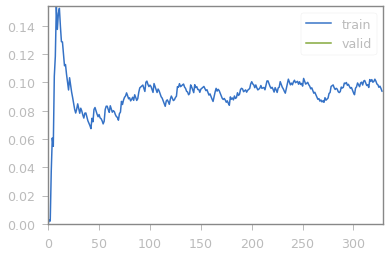

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 34 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6548


epoch,train_loss,valid_loss,accuracy,time
0,0.101723,0.077115,0.959511,01:48


Better model found at epoch 0 with accuracy value: 0.9595111012458801.


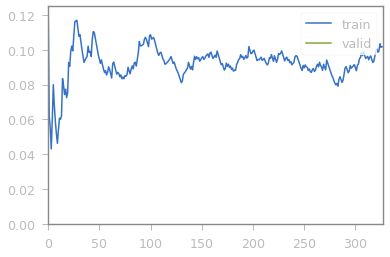

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 40 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6508


epoch,train_loss,valid_loss,accuracy,time
0,0.086490,0.081851,0.956956,01:47


Better model found at epoch 0 with accuracy value: 0.9569562077522278.


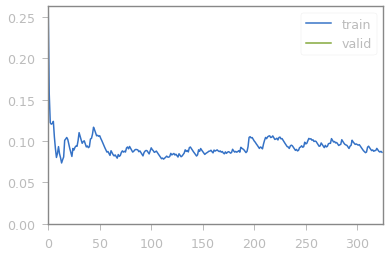

************Round:  3
TTA Accuracy:0.866486668586731
cycle 2 Error Rate is [{0: (0.6749662516874144, 12.091207504272461), 3: (2.5648717564121792, 12.871289253234863), 6: (4.349782510874456, 12.57125735282898), 9: (5.804709764511773, 12.511253356933594), 12: (7.334633268336588, 12.421244382858276), 15: (0.6299685015749179, 12.481248378753662), 18: (2.3848807559622043, 12.931293249130249), 21: (4.0797960101994875, 12.96129822731018), 24: (5.579721013949301, 13.471347093582153), 27: (7.214639268036594, 12.691271305084229), 30: (0.6149692515374228, 12.721270322799683), 33: (2.3848807559622043, 13.351333141326904)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 41 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6467


epoch,train_loss,valid_loss,accuracy,time
0,0.079747,0.089702,0.953596,01:47


Better model found at epoch 0 with accuracy value: 0.953596293926239.


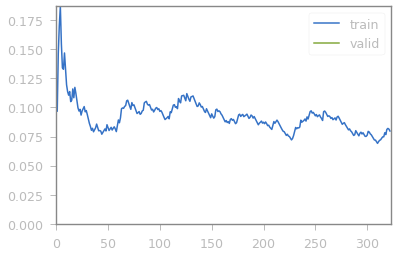

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 38 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6429


epoch,train_loss,valid_loss,accuracy,time
0,0.078664,0.067901,0.964981,01:46


Better model found at epoch 0 with accuracy value: 0.9649805426597595.


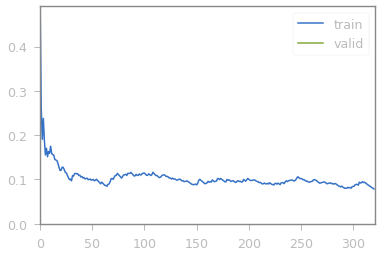

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 33 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6396


epoch,train_loss,valid_loss,accuracy,time
0,0.086474,0.083772,0.956998,01:45


Better model found at epoch 0 with accuracy value: 0.9569976329803467.


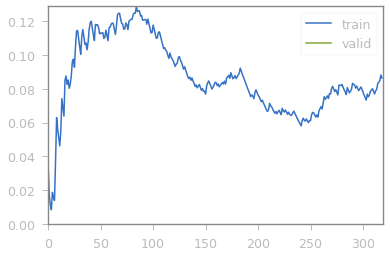

************Round:  6
TTA Accuracy:0.8637863993644714
cycle 2 Error Rate is [{0: (0.6749662516874144, 12.091207504272461), 3: (2.5648717564121792, 12.871289253234863), 6: (4.349782510874456, 12.57125735282898), 9: (5.804709764511773, 12.511253356933594), 12: (7.334633268336588, 12.421244382858276), 15: (0.6299685015749179, 12.481248378753662), 18: (2.3848807559622043, 12.931293249130249), 21: (4.0797960101994875, 12.96129822731018), 24: (5.579721013949301, 13.471347093582153), 27: (7.214639268036594, 12.691271305084229), 30: (0.6149692515374228, 12.721270322799683), 33: (2.3848807559622043, 13.351333141326904), 36: (4.064796760161993, 13.621360063552856)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 35 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6361


epoch,train_loss,valid_loss,accuracy,time
0,0.079763,0.077197,0.958333,01:45


Better model found at epoch 0 with accuracy value: 0.9583333134651184.


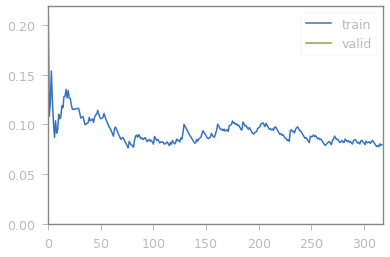

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 41 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6320


epoch,train_loss,valid_loss,accuracy,time
0,0.092517,0.071681,0.963608,01:44


Better model found at epoch 0 with accuracy value: 0.9636076092720032.


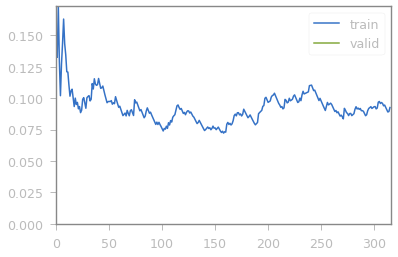

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 36 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6284


epoch,train_loss,valid_loss,accuracy,time
0,0.083829,0.083206,0.957006,01:43


Better model found at epoch 0 with accuracy value: 0.9570063948631287.


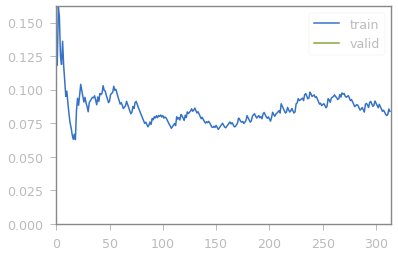

************Round:  9
TTA Accuracy:0.8715871572494507
cycle 2 Error Rate is [{0: (0.6749662516874144, 12.091207504272461), 3: (2.5648717564121792, 12.871289253234863), 6: (4.349782510874456, 12.57125735282898), 9: (5.804709764511773, 12.511253356933594), 12: (7.334633268336588, 12.421244382858276), 15: (0.6299685015749179, 12.481248378753662), 18: (2.3848807559622043, 12.931293249130249), 21: (4.0797960101994875, 12.96129822731018), 24: (5.579721013949301, 13.471347093582153), 27: (7.214639268036594, 12.691271305084229), 30: (0.6149692515374228, 12.721270322799683), 33: (2.3848807559622043, 13.351333141326904), 36: (4.064796760161993, 13.621360063552856), 39: (5.744712764361781, 12.841284275054932)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 37 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6247


epoch,train_loss,valid_loss,accuracy,time
0,0.101304,0.068808,0.964772,01:42


Better model found at epoch 0 with accuracy value: 0.9647718071937561.


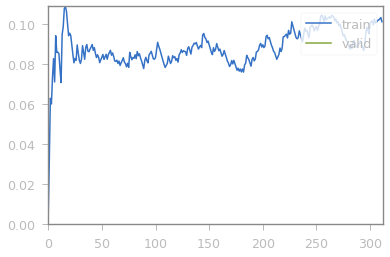

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 39 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6208


epoch,train_loss,valid_loss,accuracy,time
0,0.103738,0.071307,0.964545,01:42


Better model found at epoch 0 with accuracy value: 0.9645447134971619.


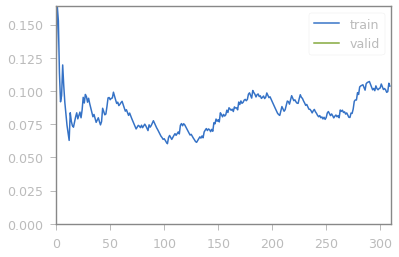

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 34 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6174


epoch,train_loss,valid_loss,accuracy,time
0,0.090817,0.063840,0.966775,01:41


Better model found at epoch 0 with accuracy value: 0.9667747020721436.


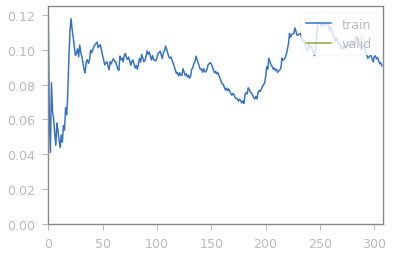

************Round:  12
TTA Accuracy:0.8670867085456848
cycle 2 Error Rate is [{0: (0.6749662516874144, 12.091207504272461), 3: (2.5648717564121792, 12.871289253234863), 6: (4.349782510874456, 12.57125735282898), 9: (5.804709764511773, 12.511253356933594), 12: (7.334633268336588, 12.421244382858276), 15: (0.6299685015749179, 12.481248378753662), 18: (2.3848807559622043, 12.931293249130249), 21: (4.0797960101994875, 12.96129822731018), 24: (5.579721013949301, 13.471347093582153), 27: (7.214639268036594, 12.691271305084229), 30: (0.6149692515374228, 12.721270322799683), 33: (2.3848807559622043, 13.351333141326904), 36: (4.064796760161993, 13.621360063552856), 39: (5.744712764361781, 12.841284275054932), 42: (7.39463026848658, 13.291329145431519)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 30 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6144


epoch,train_loss,valid_loss,accuracy,time
0,0.098271,0.073998,0.961726,01:40


Better model found at epoch 0 with accuracy value: 0.9617263674736023.


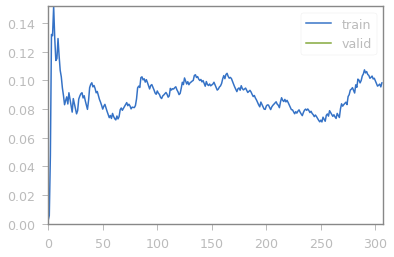

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 50
Min probability = 0.6716417910447762
Dropped 40 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6104


epoch,train_loss,valid_loss,accuracy,time
0,0.088542,0.079988,0.959836,01:40


Better model found at epoch 0 with accuracy value: 0.9598360657691956.


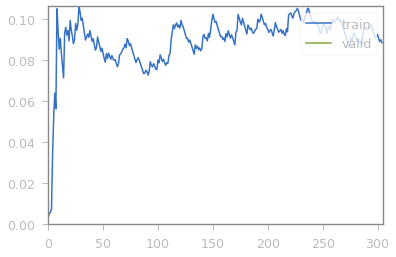

In [41]:
delta_max = 0.50
accs = []
deltas = []
err = {}

for c in range(cleaning_cycles):
    for n in range(n_training_series):
        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        loss_func = losses.DampedGCELossFlat(num_classes=num_classes,q=0.5, delta = delta, reduction='mean')
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            PATH='models/'+damp_2_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_2_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)     
    

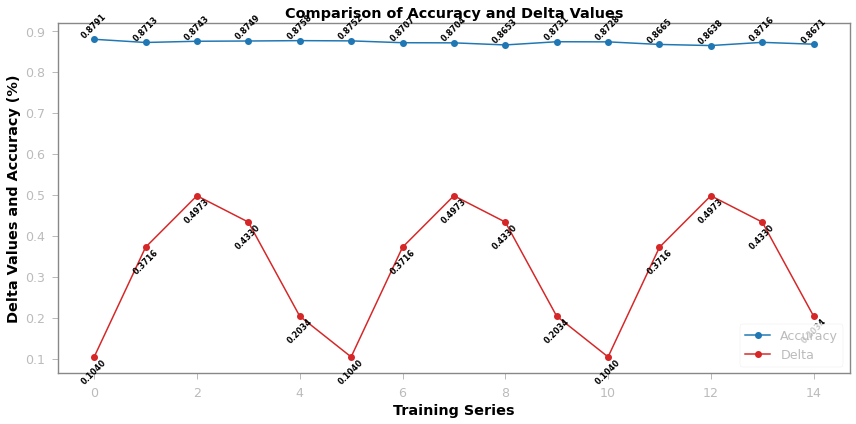

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()
